## > Importing Liberaries && Some Function

In [1]:
import tensorflow as tf
from tensorflow.keras import losses , metrics , applications ,layers  , models , callbacks , optimizers 
tf.keras.backend.set_image_data_format('channels_last')

import numpy as np
import pandas as pd

import cv2
from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sn

import os , shutil
from shutil import copyfile

from tqdm import tqdm
from pprint import pprint
import  gc

import albumentations as A
import io

2024-05-12 21:44:40.490462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 21:44:40.490513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 21:44:40.492029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def display_images(List = None, Labels = None, size = 2,cmap = 'jet',grid=None , scaling =['unit','minmax'][0]):
    try:
        if(List!=None):
            n = len(List)
            
            if(grid==None):
                grid = (1,n)
                
            plt.figure(figsize = (size * grid[1], size*grid[0]))
            for i in range(n):
                plt.subplot(grid[0],grid[1],i+1)

                img  = List[i]
                img = np.array(img,dtype = np.float32)
                
                if(np.max(img)>1):
                    if(scaling == 'unit'):
                        # print('unit rescaling image')
                        img = img/255
                    else:
                        # print('min max rescaling image')
                        img = (img - img.min())/(img.max() - img.min())
                plt.imshow(img ,cmap = cmap)
                plt.axis('off')
                if(Labels != None):
                    plt.title(Labels[i],color = 'cyan')
            plt.show()
            
    except Exception as e:
        print('Error :',e)

In [3]:
History_dict = {}
Model_dict = {}

def add_to_model_dict(model ,model_name):
    if(model_name in Model_dict.keys()):
        print("model_already_there")
    else:
        Model_dict[model_name] = model

def add_to_history_dict(history ,model_name):
    if(model_name in History_dict.keys()):
        print("model_already_there")
    else:
        History_dict[model_name] = history

## > Loading Data

###  || Load Data from google drive 

In [4]:
# Model_dict

In [5]:
dataset_name = 'Hrf'
base_path = os.getcwd()+'/../input/'

dataset_base_path = base_path+'dataset-hrf/'+dataset_name

In [6]:
preprocesses =[
    "> Clahe , smoothing , Edge Detection" ,
    "> Resizeing  & Resclaing",
    "> Random Contrast , sharpness, Brightness",
    "> Random  Zoom , Shift , Flip , Rotate90",
]

In [7]:
config ={
    'dataset' : {
        '_image_shape' : (576,544),
    },
    'model' : {
        
    },
    
    'training' : {
        
    },
    'preprocesing' : '\n'.join(preprocesses),
}

Model_names = [ 'simple_unet' ,'residual_unet' ,'recuurent_unet','r2_unet' , 'residual_attention_unet']

In [8]:
# Flow data from directories
train_images_path = dataset_base_path +  '/Data/train/images/'
train_masks_path = dataset_base_path + '/Data/train/masks/'
val_images_path = dataset_base_path + '/Data/val/images/'
val_masks_path = dataset_base_path + '/Data/val/masks/'
test_images_path = dataset_base_path + '/Data/test/images/'
test_masks_path = dataset_base_path + '/Data/test/masks/'

In [9]:
def get_data(images_path , masks_path ):
    Images = []
    Masks = []
    try:
        ## Note : image Path ad Maks dir are same
        image_dirs = sorted(os.listdir(images_path)) 
        mask_dirs = sorted(os.listdir(masks_path))
        dirs = np.intersect1d(image_dirs , mask_dirs)
        
        try :
            for dir_ in tqdm(dirs):
                image_dir = images_path + dir_
                mask_dir = masks_path + dir_
                
                image = Image.open(image_dir)
                mask = Image.open(mask_dir)
                
                image = image.resize((1024,1024))
                mask = mask.resize((1024,1024))

                
                Images.append(np.array(image,dtype = np.uint8))
                Masks.append(np.array(mask , dtype = np.uint8))
            print( 'number of images :' ,len(Images))
        except Exception as e:
            print("Error Occured ",e)
            print(image)
    
    except Exception as e:
        print("Error Occured for path",e)

    return Images ,Masks

In [10]:
train_images , train_masks = get_data( train_images_path , train_masks_path)
test_images , test_masks = get_data( test_images_path , test_masks_path)
val_images , val_masks = get_data( val_images_path , val_masks_path)

100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


number of images : 31


100%|██████████| 9/9 [00:04<00:00,  2.10it/s]


number of images : 9


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

number of images : 5


In [11]:
# List1 =['abc','bcd','aef']
# List2 =['abc',"sdb",'esf']

# List1 = sorted(List1)
# List2 = sorted(List2)

# np.intersect1d(List1,List2)

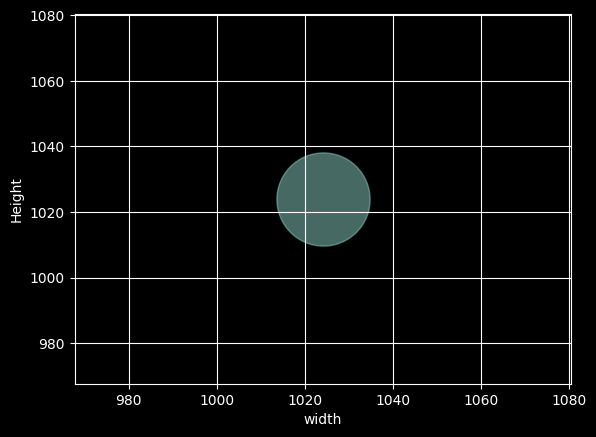

In [12]:
Dict = {}
for images in [train_images , test_images , val_images]:
    for image in images:
        im_shape = image.shape[:2]
        if(im_shape not in Dict.keys()):
            Dict[im_shape]=0
        Dict[im_shape] +=1

arr = np.array(list (Dict.keys())) 
num = np.array(list(Dict.values()))

plt.scatter(arr[:,1],arr[:,0] , s=num *100 ,alpha=0.5)
plt.ylabel('Height')
plt.xlabel('width')
plt.grid()
plt.show()

In [13]:
Dict 

{(1024, 1024): 45}

In [14]:
factor = 32
im_h =  1024
im_w = 1024

desired_shape = ( int(( im_h//factor )* factor) , int((im_w//factor) *factor) )
# desired_shape = (512,512)
config['dataset']['_image_shape'] = desired_shape

def  resize_images_to_numpy(Data ):
    List = []
    for image in tqdm(Data):
        # print(image.dtype)
        new_image = np.array(Image.fromarray(image).resize((desired_shape[1],desired_shape[0])))
        List.append(new_image)
        
    return np.array(List , dtype = np.float32)
    
def  resize_masks_to_numpy(Data):
    List = []
    for mask in tqdm(Data): ## implies RGB
        new_mask = Image.fromarray(mask).resize((desired_shape[1],desired_shape[0]))
        if( np.array(new_mask).ndim == 3):
            new_mask = np.arranp.sum(new_mask , axis=-1,keepdims=True)
        else: ## Implies  Graysclae
            new_mask = np.expand_dims(new_mask, axis = -1)
        
        new_mask = np.where(new_mask > 0 ,1 ,0)
    
        List.append(new_mask)
    return np.array(List , dtype = np.float32)

train_images = resize_images_to_numpy(train_images )
train_masks  = resize_masks_to_numpy(train_masks )

test_images = resize_images_to_numpy(test_images )
test_masks  = resize_masks_to_numpy(test_masks )

val_images = resize_images_to_numpy(val_images )
val_masks  = resize_masks_to_numpy(val_masks )

100%|██████████| 5/5 [00:00<00:00, 364.38it/s]


## > Preprocessing (only form images) & Datasplit

In [15]:
def image_01float_to_unit8(image_float):
    return (image_float*255).astype(np.uint8)
    
def image_clahe_gray(image , clipLimit  = 10 , tileGridLen = 10):
    clahe = cv2.createCLAHE(clipLimit=clipLimit , tileGridSize= (tileGridLen,tileGridLen) )
    # print(np.shape(image))
    # print(np.max(image) , np.array(image).dtype)
    clahe_image = clahe.apply(image)
    
    return clahe_image
# //---------------------------------------------------------------------------------------------------------------
def morphological_operations(image, kernel_size = 15,channel = 1):
    # Convert RGB image to grayscale
    # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    if( np.ndim(image)==3):
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
        # grayscale_image_cl = image_clahe_gray(grayscale_image,4,16)
    # Apply morphological operations (Top-hat filtering)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    tophat_result = cv2.morphologyEx(grayscale_image, cv2.MORPH_TOPHAT, kernel)
    return tophat_result
    
# Apply gamma correction-----------------------------------------------------------------------------------
def image_gamma_corr( image , gamma = 1.5): ## Uint8 .
    std_image = image_standarize(image)
    
    corrected_image = np.power(std_image , 1/gamma)
    # Convert back to uint8 format
    corrected_image_uint8 = (corrected_image * 255).astype(np.uint8)
    return corrected_image_uint8
# ///-----------------------------------------------------------------------------------------------------------------
from skimage.filters import frangi

def frangi_vessel_enhancement(image , alpha = 0.5 ,beta=0.5, gamma=1 ,kernel_size = 5,channel = 1):
    # Convert RGB image to grayscale
    if(np.ndim(image) == 3):
        # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
    # Apply Frangi filter
    frangi_result = frangi(grayscale_image ,alpha = alpha ,beta=beta ,gamma = gamma ,) 
    frangi_result =  image_01float_to_unit8(frangi_result)
    # frangi_result = frangi(grayscale_image.
    blurred = cv2.GaussianBlur(frangi_result  , (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    return blurred 
# ///-----------------------------------------------------------------------------------------------------------------
def image_normalise(image):  # for any type of images 
    mean = np.mean(image, axis=(0, 1))
    std_dev = np.std(image, axis=(0, 1))
# Normalize image
    normalised_image = (image - mean) / std_dev
    return normalised_image
    
def clip_image(image , clip_range =[0,2]): # for any type of images
    normalised_image = image_normalise(image)
    clip_image = np.clip( normalised_image, *clip_range)
    clip_std_image = (clip_image - clip_range[0] )/ (clip_range[1]-clip_range[0])
    clip_image = image_01float_to_unit8(clip_std_image)
    return clip_image

# //--------------------------------------------------------------------------------------------------
def  image_standarize(image_float): ## for all type of image
    # Calculate mean and standard deviation for each channel
    min_ = np.min(image_float, axis=(0, 1))
    max_ = np.max(image_float, axis=(0, 1))
    # Normalize image
    standarized_image = (image_float - min_) / (max_ - min_)
    return standarized_image 

In [16]:
num = 4
func_Dict ={
    'clahe' :image_clahe_gray,
    'gamma_correction':image_gamma_corr,
    'morphological_operations':morphological_operations,
#     'frangi_vessel_enhancement' : frangi_vessel_enhancement,
    'norm_clip': clip_image,
}

In [17]:
param_Dict = {'clahe': {'clipLimit': np.array([ 4,  8, 12, 16]),
           'tileGridLen': np.array([17, 27, 28, 31])},
 'gamma_correction': {'gamma': np.array([0.5, 0.6, 0.7, 0.8])},
 'morphological_operations': {'kernel_size': np.array([100, 133, 166, 200])},
 'norm_clip': {'clip_range': np.array([[ 0.  ,  2.  ],
       [ 0.  ,  2.5 ],
       [ 0.  ,  3.  ],
       [ 0.25,  2.25],
       [-0.25,  2.  ]])}}
# param_Dict = {
#     'clahe' : {
#         'clipLimit' : np.linspace(4,16,num).astype('int'),
#         'tileGridLen' : np.random.randint(16,32,(num,),)
#    },
    
#      'gamma_correction':{
#         'gamma' :np.linspace(0.5,0.8,num),
#     },
    
#      'morphological_operations':{
#         'kernel_size' :np.linspace(100,200,num).astype('int'),
#     },
# #      'frangi_vessel_enhancement':{
# #         'kernel_size': 2* np.random.randint(0,2,(num,))+1,
# #         'gamma':np.random.uniform(0.5,2.5,(num,))
# #     },
#     'norm_clip':{
#         'clip_range':np.array([[0,2],[0,2.5] ,[0,3],[0.25,2.25],[-0.25,2]])
#     },
# }
# pprint(param_Dict)

In [18]:
theta = 50
def concat_aug(image):
    image_List = []
    
    image = np.array(image,dtype=np.uint8)
    image_List.append(image[...,0])
    image_List.append(image[...,1])
    image_List.append(image[...,2])
    image_green = image[...,1]
    
    image_roi = np.where(np.max(image,axis =-1) > theta ,1,0)
#     display_image(image_roi)
    
    for op_name , func in func_Dict.items():
        
        for j in range(num):
            Dict = {}
            for param , vals in param_Dict[op_name].items():
                Dict[param] = vals[j]
                
        ##  will focus on green pixel only 
            img = func(image_green,**Dict)
            # print( op_name , np.max(img),np.shape(img))
            image_List.append(img*image_roi)
            
    image_array = np.moveaxis(image_List ,0, -1)
    return image_array
    
def Augment_train(X):
    X_new = []
    for image in tqdm(X):
        new_image_set = concat_aug(image)        
        X_new.append(new_image_set)
    return np.array(X_new , dtype = 'uint8')

In [19]:
%time train_images = Augment_train(train_images)
%time test_images = Augment_train(test_images)
%time val_images = Augment_train(val_images)

100%|██████████| 31/31 [01:44<00:00,  3.36s/it]


CPU times: user 1min 44s, sys: 2.77 s, total: 1min 47s
Wall time: 1min 45s


100%|██████████| 9/9 [00:30<00:00,  3.40s/it]


CPU times: user 30.7 s, sys: 869 ms, total: 31.5 s
Wall time: 31 s


100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


CPU times: user 16.7 s, sys: 439 ms, total: 17.2 s
Wall time: 16.9 s


In [20]:
 train_images.shape ,test_images.shape , val_images.shape

((31, 1024, 1024, 19), (9, 1024, 1024, 19), (5, 1024, 1024, 19))

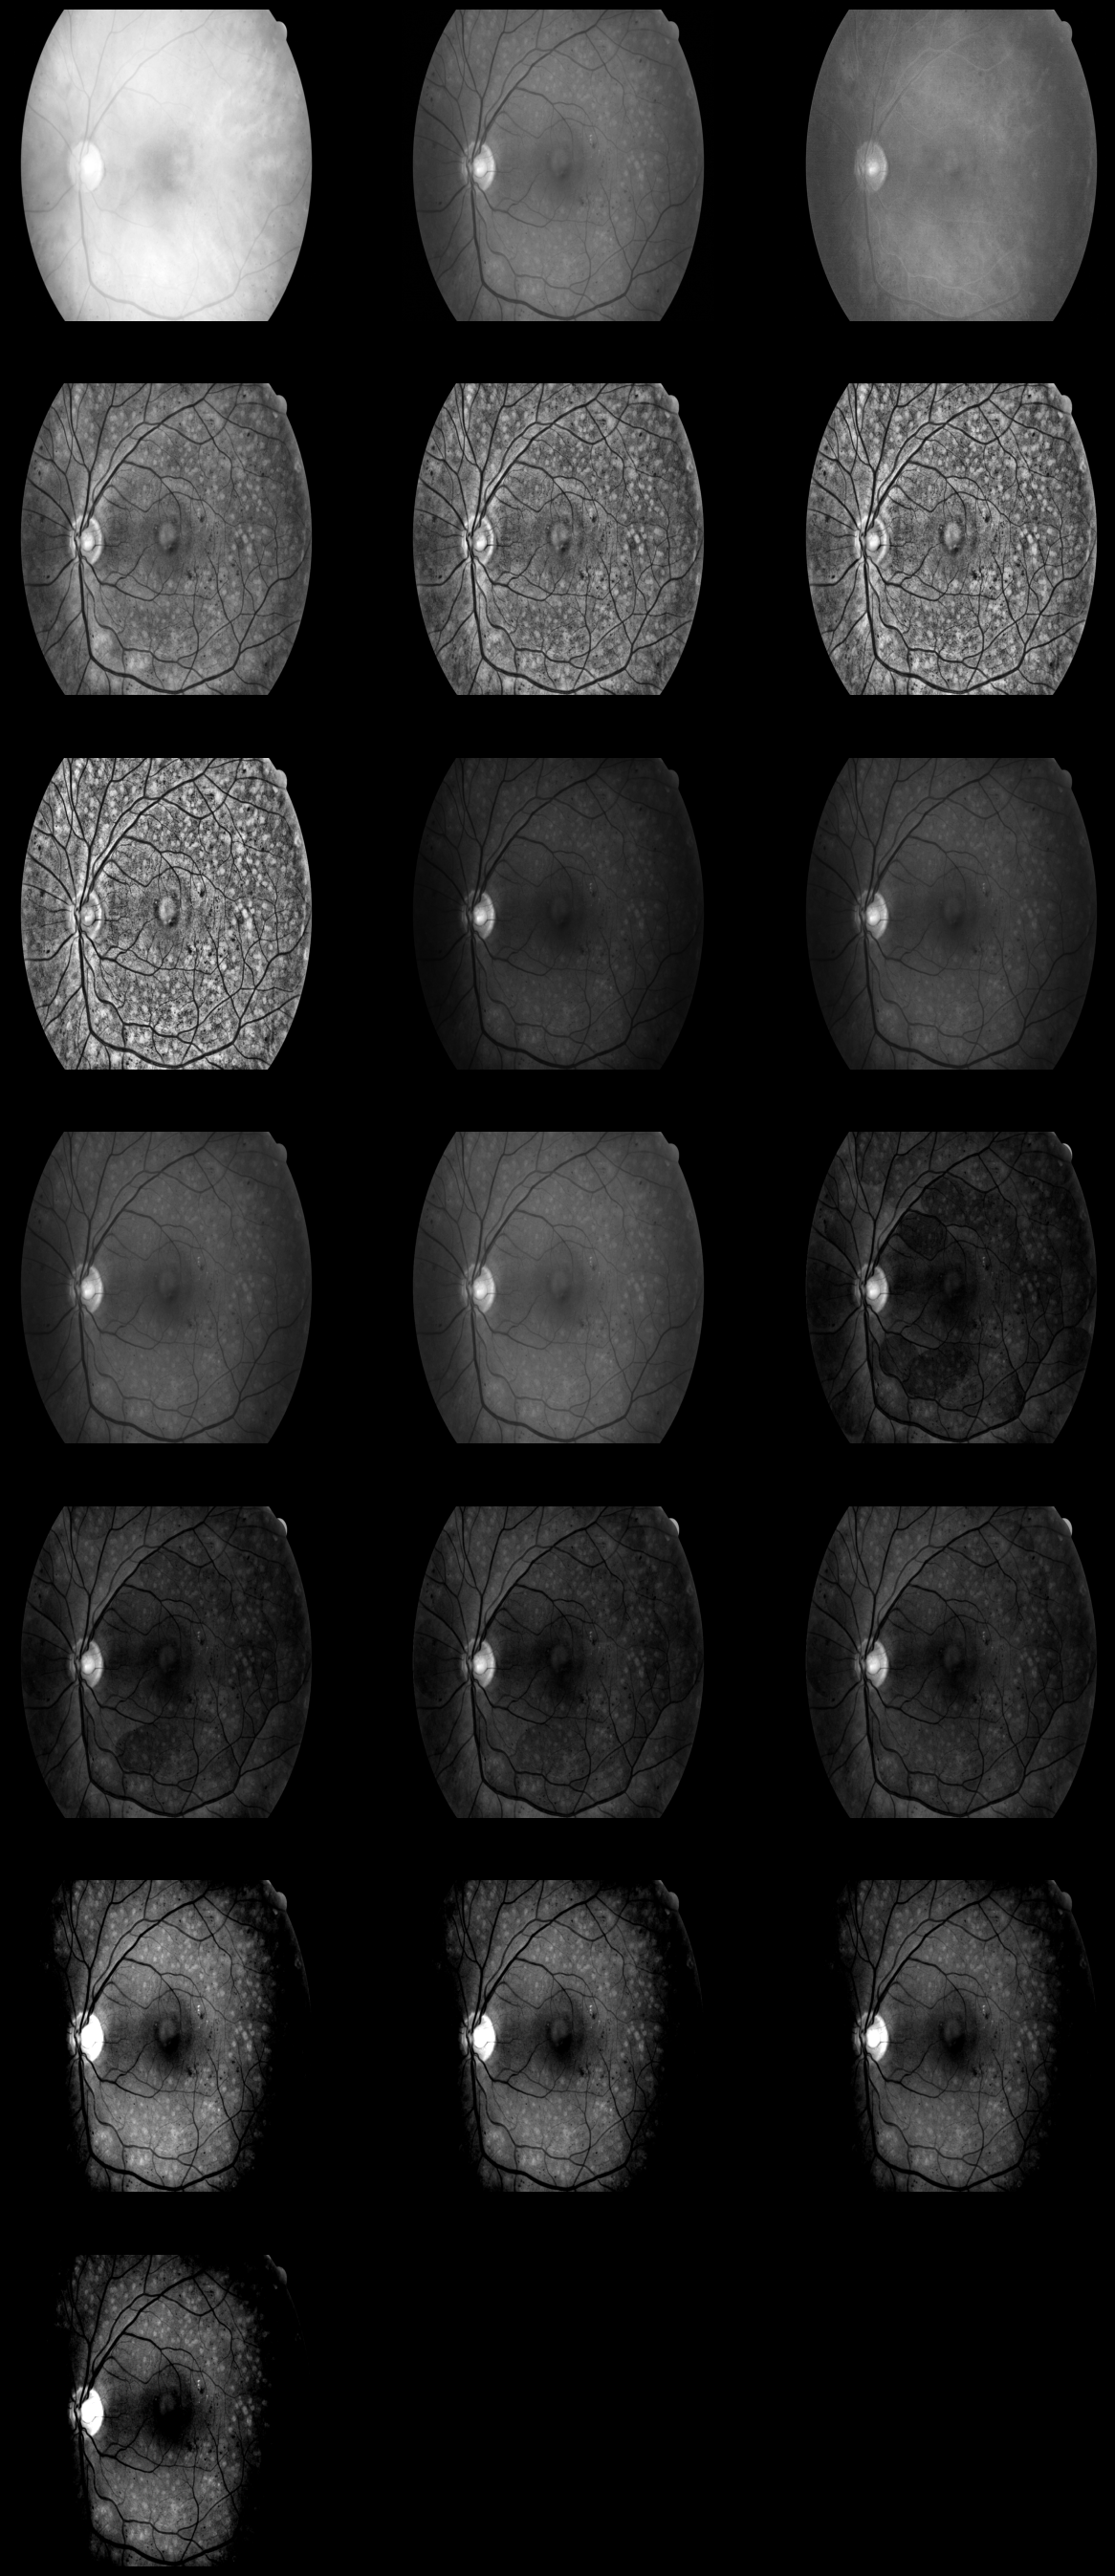

In [21]:
List = []
index = 0
num = 19
for i in range(num):
    List.append(val_images[index][...,i])

display_images(List,cmap = 'gray',size = 5,grid=(10,3))

## > Model Building & importing

### > get the base Models

In [22]:
# !pip install segmentation_models

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [23]:
# !pip install keras_unet_collection

In [24]:
# from keras_unet_collection import models as unet_models
# from keras_unet_collection import losses as unet_losses

In [25]:
config['dataset']['_image_shape'] = desired_shape

In [26]:
# num = 0
# model_name = Model_names[0]
# # backbone_name ='EfficientNetB0'
# # backbone_name ='efficientnetb0'

# image_shape =  config['dataset']['_image_shape'] 

In [27]:
import sys

sys.path.append(base_path + "my-unet-collection/MyKerasLiberary") 

import unet_models as unet_models

In [28]:
num = 3
model_name = Model_names[num]
image_shape =  config['dataset']['_image_shape'] 
n_channel = train_images[0].shape[-1]


unet_models.General_Config['image_shape']= image_shape
unet_models.General_Config['n_channel']= n_channel
unet_models.Model_Config['n_level'] = 4
unet_models.Model_Config['n_unit'] = 32
unet_models.Model_Config['dilation'] = 1
Model = unet_models.BuildUnet(num = num)

In [29]:
# model_name = Model_names[4]
# image_shape =  config['dataset']['_image_shape'] 
# n_channel = train_images[0].shape[-1]


# unet_models.General_Config['image_shape']= image_shape
# unet_models.General_Config['n_channel']= n_channel
# unet_models.Model_Config['n_level'] = 4
# unet_models.Model_Config['n_unit'] = 32
# unet_models.Model_Config['dilation'] = 1

# Model = unet_models.BuildUnet(num = 0 , has_attention=True)

In [30]:
models.clone_model(Model)

<Functional name=Unet_Model, built=True>

In [31]:
Model.summary()

Model: "Unet_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 19)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1024,      │        640 │ input_layer[0][0] │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1024,      │      9,248 │ conv2d[0][0]      │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024,      │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1024,      │          0 │ conv2d[0][0],     │
│                     │ 1024, 32)         │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1024,      │      9,248 │ add[0][0]         │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1024,      │          0 │ conv2d[0][0],     │
│                     │ 1024, 32)         │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1024,      │      9,248 │ add_1[0][0]       │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1024,      │      9,248 │ activation_2[0][… │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1024,      │          0 │ activation_2[0][

 Total params: 27,971,201 (106.70 MB)

 Trainable params: 27,950,593 (106.62 MB)

 Non-trainable params: 20,608 (80.50 KB)

In [32]:
# def get_segmentation_model_0():
#     n_class = 1
#     BaseModel = sm.Unet(backbone_name = backbone_name , 
#                                     input_shape = image_shape+(3,),
#                                     encoder_weights='imagenet',
#                                      classes=1,
#                                     activation = 'sigmoid',
#                                     encoder_freeze = True,
#                                     decoder_block_type ='upsampling',
#                                    )
#     return BaseModel
# def get_segmentation_model_1():
#     Model = unet_models.unet_2d(image_shape+(3,) ,
#                             n_labels = 1,
#                             filter_num=[32,64,128,256,512],
#                             output_activation='Sigmoid',
#                             weights='imagenet',
#                             # name = 'my_unet',
#                             batch_norm=True,
#                             backbone=backbone_name,
#                             freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_2():
#     Model = unet_models.r2_unet_2d(image_shape + (3,),
#                                n_labels = 1,
#                                 filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                 # name = 'my_unet',
#                                batch_norm=True,
#                                 # backbone='bacbackbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_3():
#     Model = unet_models.att_unet_2d(image_shape+(3,) ,
#                                n_labels = 1,
#                                filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                # name = 'my_unet',
#                                batch_norm=True,
            
#                                 # backbone = backbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_4():
#     Model = unet_models.unet_3plus_2d(
#                                 image_shape+(3,) ,
#                                 n_labels = 1,

#                                 filter_num_down=[32,64,128,256,512],
#                                 # filter_num_up=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                backbone='EfficientNetB0',
#                                weights='imagenet',
#                                 batch_norm=True,
#                                 # name = 'my_unet',
#                                 freeze_backbone=True,
#                                 filter_num_skip = [64,]*4,
#               )
#     return Model

### > build Model 

In [33]:
# sm.get_preprocessing(backbone_name)(image)

In [34]:
# Model = get_segmentation_model_0()
# Model.summary(100)

In [35]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# x_rescale = layers.Rescaling(1/255.)(fn_input)

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)
# x_add = layers.BatchNormalization()(x_add)

# fn_output = layers.Conv2D(1,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'sigmoid')(x6)

# # fn_output  = Model(x1)
# pre_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# pre_Model.summary(100)
# models.clone_model(pre_Model)

In [36]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel ,))

# x1 = layers.Conv2D(n_unit, kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x3  = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x_add = layers.Add()([x1,x2,x3]) 
# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)

# x_out = un_model_1(fn_input)
# x_conc =  layers.Concatenate()([x_out*255 , x_add])

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_conc)
# x6 = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same',dilation_rate = dilation ,kernel_initializer= 'ones',activation = 'relu')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs = x6,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [37]:
# n_unit = 8
# dilation = 2 
# n_channel = 13 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# # x_rescale = layers.Rescaling(1/255.)(fn_input)
# x_rescale = fn_input

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# # x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'relu')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# # x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# # x6 = layers.BatchNormalization()(x6)

# fn_output = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [38]:
# un_model_1 = pre_Model
# un_model_1.set_weights(Unet_Model.get_weights())

In [39]:
# un_model_2 = pre_Model
# un_model_2.set_weights(un_model_1.get_weights())

In [40]:
# Unet_Model = models.Sequential([prev_Model,Model])
# Unet_Model.summary()
# models.clone_model(Unet_Model)

In [41]:
# Unet_Model = pre_Model
# Unet_Model = Model

In [42]:
# Unet_Model(np.zeros(shape = (1,)+image_shape+ (28,))).shape

## > Model Training 

In [32]:
model_weights_path1 = 'unet_model_best1.weights.h5'
model_weights_path2 = 'unet_model_best2.weights.h5'
model_weights_path3 = 'unet_model_best3.weights.h5'
model_weights_path4 = 'unet_model_best4.weights.h5'
model_weights_path5 = 'unet_model_best5.weights.h5'
model_weights_path6 = 'unet_model_best6.weights.h5'


checkpoint_callback = callbacks.ModelCheckpoint(  ## To save Best Models
    model_weights_path1,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True, ## will save best weights. 
    save_weights_only = True, ## If false will save whole model .. .
    mode = 'auto', # if monitor val_loss that it will be min else if val_accuracy that it will be Max..
    save_freq = 'epoch', ## we will do this after every epoch .
)

plateau_callback = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.6, ## reduce by this factor . ## lr = lr*0.1
    patience = 5, ## wait till these number of epochs ,
    verbose = 1,
    mode = 'auto', ## similar to what studied above,,i..e Min or Max..
    min_delta = 0.0, ## if change is less than delta than we will consider it as no improvement . 
    cooldown = 0,  ## to wait after we have updated our lr ,,
    min_lr = 0, ## dont go below this lr.
)

In [33]:
# os.removedirs(base_path + 'liberary')

In [34]:
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss()
# bce_loss = sm.losses.BinaryCELoss()
# jaccard_loss = sm.losses.JaccardLoss()
# hybrid_loss1 = dice_loss + 1.*(focal_loss)
# hybrid_loss2 = dice_loss + 1.*(bce_loss) + 1.*jaccard_loss
# hybrid_loss3 = jaccard_loss + bce_loss
# # loss = dice_loss
# # loss = hybrid_loss1
# # loss = bce_loss
# # loss = focal_loss
loss = sm.losses.JaccardLoss()
# # loss = sm.losses.binary_focal_jaccard_loss
# # loss = hybrid_loss3

In [35]:
def specificity(y_true, y_pred):
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float32'))
    total_background = tf.keras.backend.sum(1 - y_true)
    return tn / (total_background + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float32'))
    total_foreground = tf.keras.backend.sum(y_true)
    return tp / (total_foreground + tf.keras.backend.epsilon())

# Assuming y_true and y_pred are segmentation masks with values in {0, 1} for background and foreground, respectively
# Compute specificity and sensitivity
# spec = specificity(y_true, y_pred)
# sens = sensitivity(y_true, y_pred)

In [36]:
metrics_ = [
            # metrics.MeanIoU(num_classes=2 , name = 'mean_iou_score') ,
            sm.metrics.IOUScore(name = 'iou_score',),
            'accuracy', 
            sm.metrics.FScore(name = 'f1score'),
            metrics.AUC(name = 'auc',),
            # metrics.BinaryIoU(name='binary_iou'),
            specificity,
            sensitivity
           ]

lr = 0.005
Model.compile(
    optimizer = optimizers.Adam(learning_rate=lr),
    loss = loss,
    metrics = metrics_,
)

In [37]:
History = {}
def add_to_history(history):
    for metric,values  in history.history.items():
        if(metric not in History.keys()):
            History[metric] = []
        History[metric] += values

### Augmentatiion

In [38]:
transform = A.Compose(
    [
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
    ]
)

def Augment_it(X_train ,Y_train,rescale = False):
    Image_List = []
    Mask_List = []
    for image , mask  in zip(X_train,Y_train):
        Dict = { 'image':image,
                        'mask':mask ,}
        trans_data = transform(**Dict)
        
        Image_List.append(trans_data['image'])
        Mask_List.append(trans_data['mask'])
    
    Image_List = np.array(Image_List)         
    Mask_List = np.array(Mask_List)         
    
    if(rescale):
        Image_List/=255.
    return Image_List,Mask_List

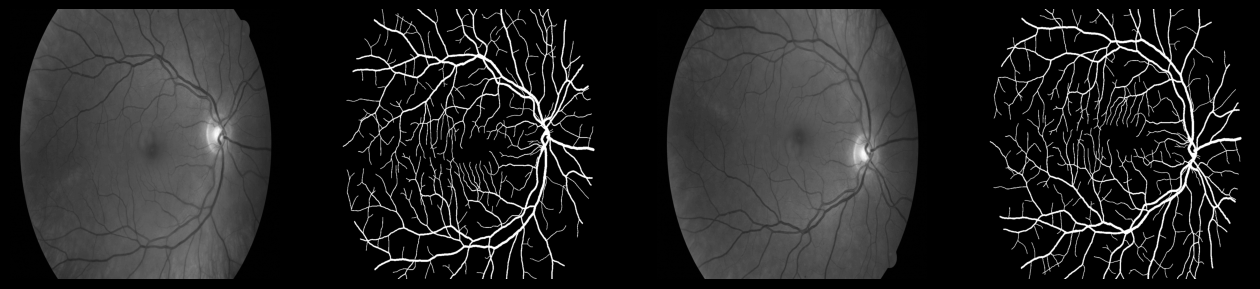

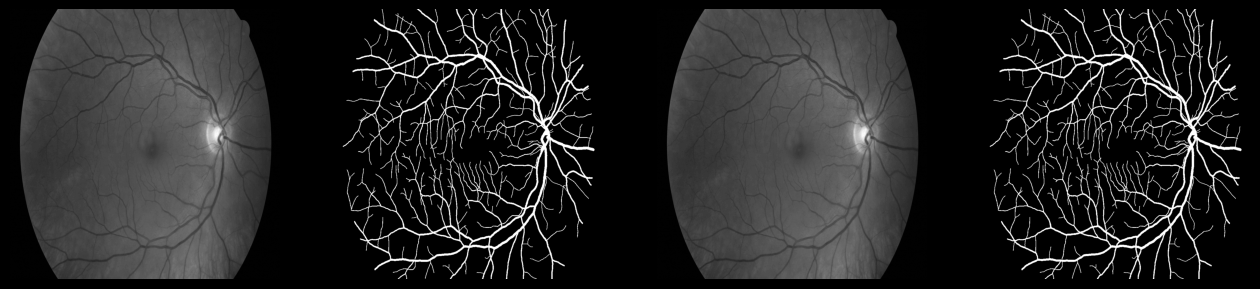

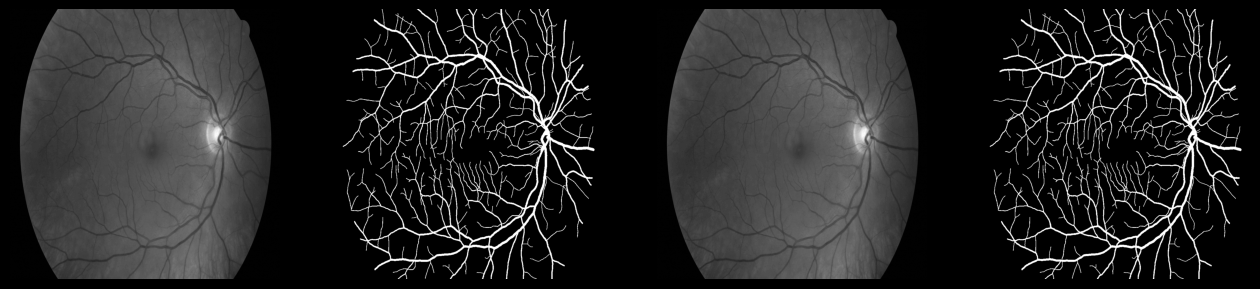

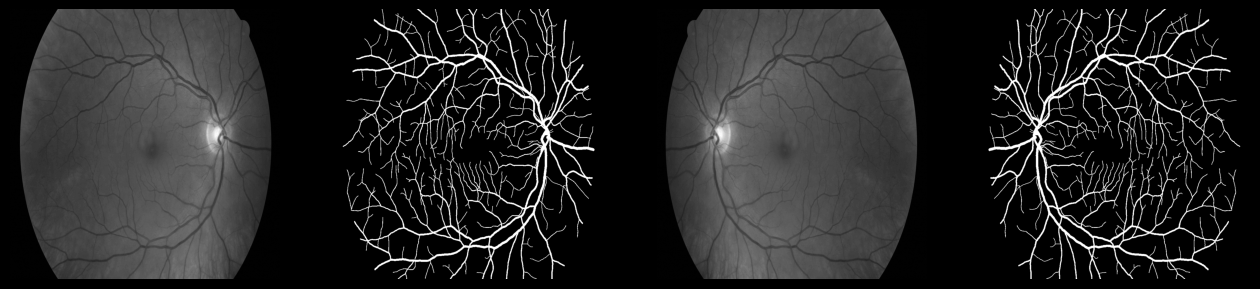

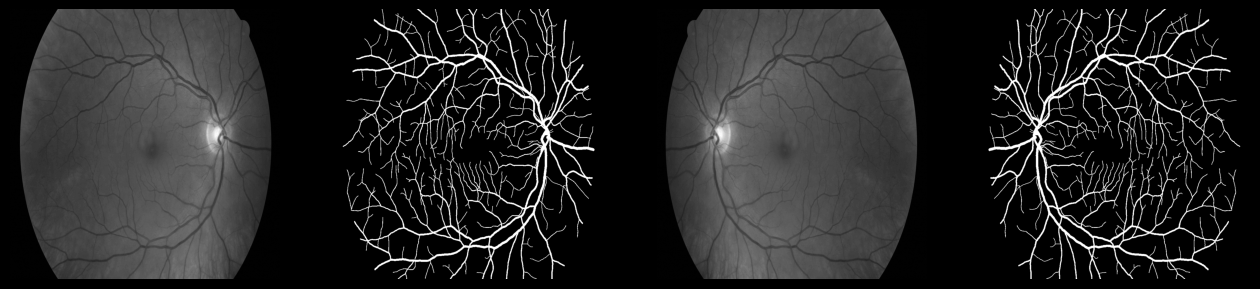

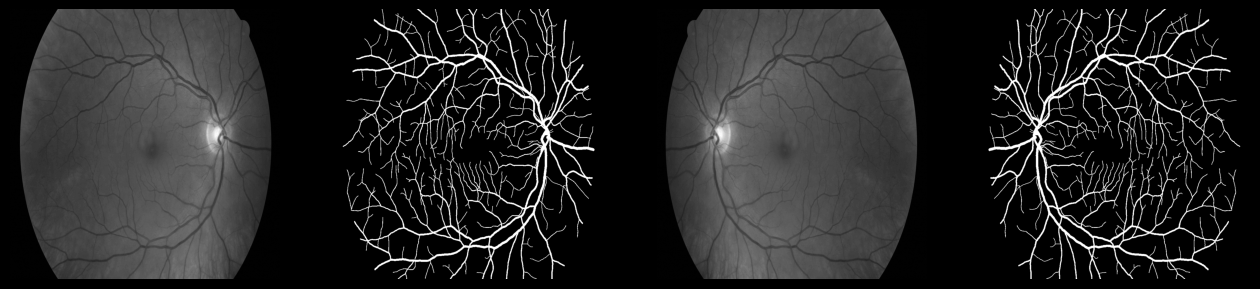

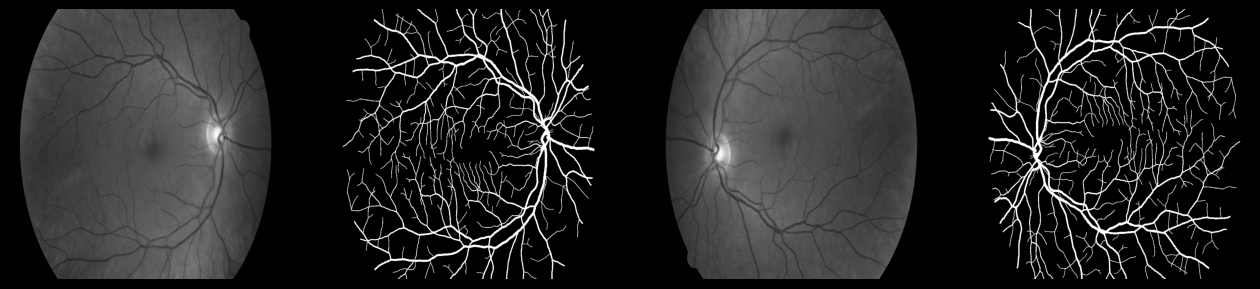

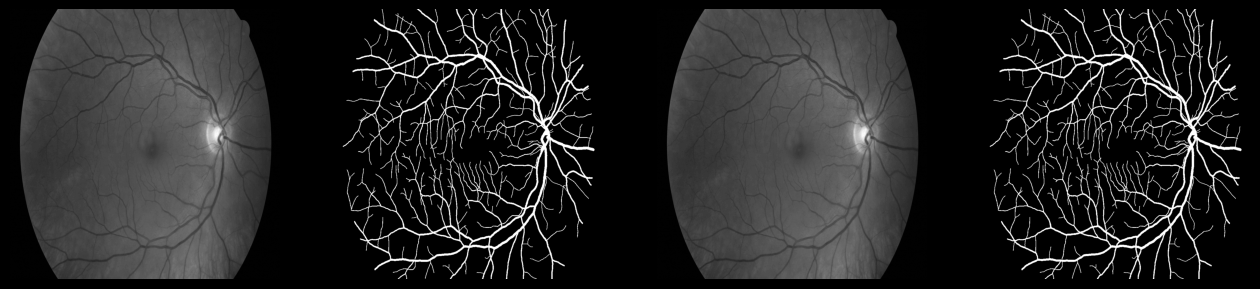

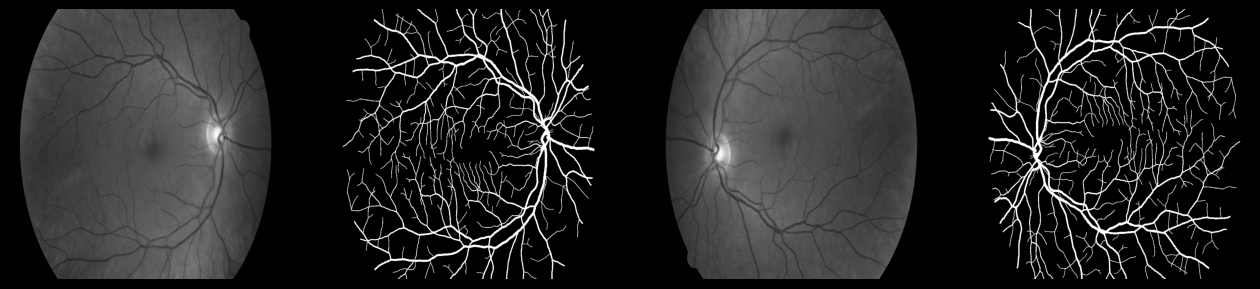

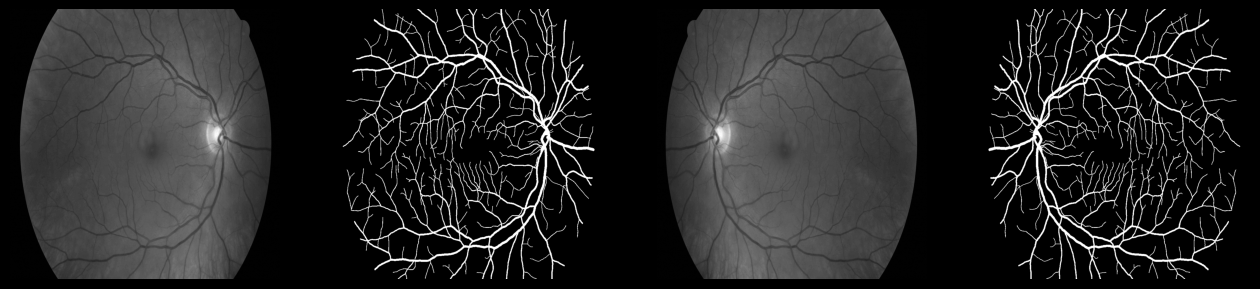

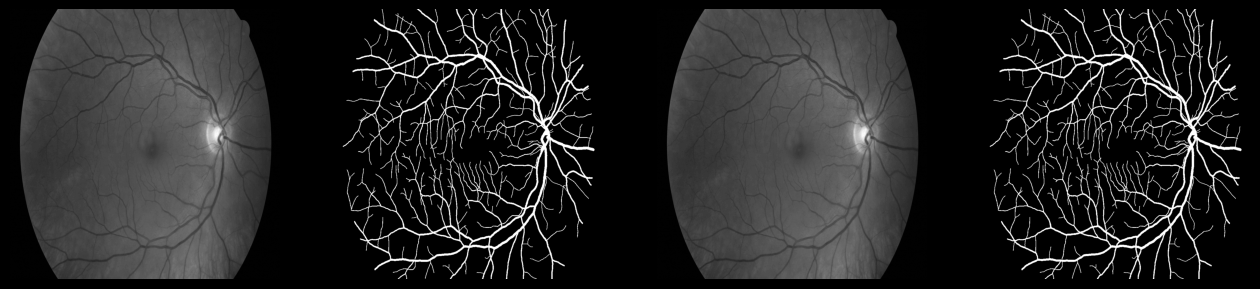

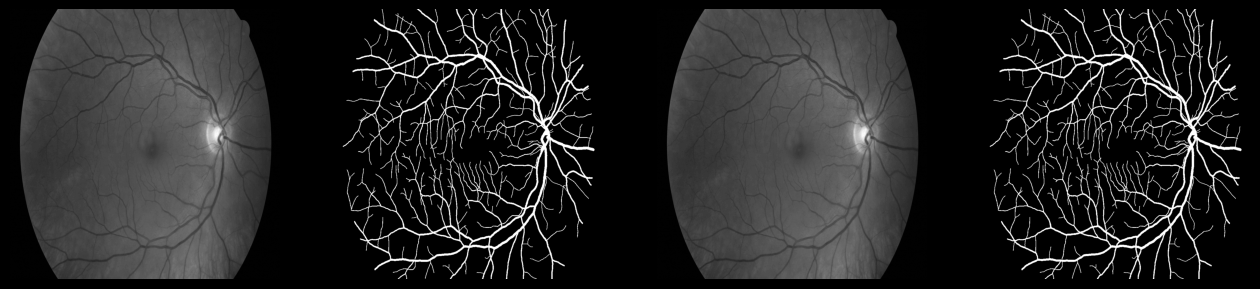

In [39]:
num_ = 12
index = 1
for i in range(num_):
    X_train,Y_train =Augment_it(train_images[:1],train_masks[:1])
    display_images([train_images[0][...,index],train_masks[0] ,X_train[0][...,index],Y_train[0]] ,size = 4,cmap = 'gray')

### Training

In [40]:
batch_size = 2

# back_bone_name =  'efficientnetb0' 
# preprocess = sm.get_preprocessing(back_bone_name)

indexes = np.arange(train_images.shape[0])
patience = 5
temp_wait = 0
factor = 0.5
lr_scale = 1.2
monitor = 'val_loss'
best_monitor_value = 1234647  

In [41]:
n_epoch = 150

for epoch in tqdm(range(n_epoch)):
    indexes = np.random.permutation(indexes)

    X_train ,Y_train = train_images[indexes] , train_masks[indexes] 
    X_train ,Y_train = Augment_it(X_train ,Y_train )
    
    ## preprocessing .......................................................................................................
    # X_train = preprocess(X_train)
    # X_val = preprocess(val_images)
    
    ## Plateau Callback .....................................................................................................
    if(monitor in History.keys()) :
        # print(temp_wait ,History[monitor][-1] , best_monitor_value)
        if (History[monitor][-1] < best_monitor_value):
            best_monitor_value = History[monitor] [-1]
            temp_wait = patience
        else:
            if(temp_wait > 0):
                temp_wait -= 1
            else:
                prev_lr =np.array(Model.optimizer.learning_rate)
                new_lr = (prev_lr) * factor
                setattr(Model.optimizer, 'learning_rate',new_lr)
                print(f">>>>>>>> | Changing Learning Rate from {prev_lr} to {new_lr}")
                
                patience = int(patience * lr_scale)
                temp_wait = patience
    print('>>>>>>>> | Learning is :', np.array(Model.optimizer.learning_rate),"| Patience is",patience ,'| temp_wait is',temp_wait)
    # ///----------------------------------------------------------------------------------------
    history = Model.fit(
                X_train,
                Y_train,
                
                validation_data=[val_images ,val_masks],
                epochs  = 1,
                batch_size = batch_size,
                callbacks=([checkpoint_callback , 
#                             plateau_callback,
                           ]
                        ),
                shuffle = False,
        
                )
    add_to_history(history)

  0%|          | 0/150 [00:00<?, ?it/s]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0


2024-05-12 21:50:03.344453: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,32,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 21:50:03.629298: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.284957349s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,32,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 21:50:05.688146: E exter

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8099 - auc: 0.8258 - f1score: 0.3899 - iou_score: 0.2534 - loss: 0.7469 - sensitivity: 0.7252 - specificity: 0.7022
Epoch 1: val_loss improved from inf to 0.90394, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 234s 7s/step - accuracy: 0.8132 - auc: 0.8289 - f1score: 0.3977 - iou_score: 0.2602 - loss: 0.7402 - sensitivity: 0.7272 - specificity: 0.7089 - val_accuracy: 0.0969 - val_auc: 0.5005 - val_f1score: 0.1751 - val_iou_score: 0.0961 - val_loss: 0.9039 - val_sensitivity: 1.0000 - val_specificity: 0.0011


  1%|          | 1/150 [03:56<9:47:16, 236.49s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9397 - auc: 0.8934 - f1score: 0.7172 - iou_score: 0.5598 - loss: 0.4402 - sensitivity: 0.7090 - specificity: 0.9663
Epoch 1: val_loss improved from 0.90394 to 0.90390, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9398 - auc: 0.8936 - f1score: 0.7180 - iou_score: 0.5607 - loss: 0.4392 - sensitivity: 0.7099 - specificity: 0.9664 - val_accuracy: 0.0978 - val_auc: 0.5008 - val_f1score: 0.1752 - val_iou_score: 0.0961 - val_loss: 0.9039 - val_sensitivity: 0.9995 - val_specificity: 0.0021


  1%|▏         | 2/150 [04:38<5:00:57, 122.01s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9490 - auc: 0.8971 - f1score: 0.7640 - iou_score: 0.6192 - loss: 0.3809 - sensitivity: 0.7438 - specificity: 0.9743
Epoch 1: val_loss improved from 0.90390 to 0.90299, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9489 - auc: 0.8970 - f1score: 0.7638 - iou_score: 0.6190 - loss: 0.3812 - sensitivity: 0.7440 - specificity: 0.9742 - val_accuracy: 0.1109 - val_auc: 0.5062 - val_f1score: 0.1767 - val_iou_score: 0.0970 - val_loss: 0.9030 - val_sensitivity: 0.9951 - val_specificity: 0.0170


  2%|▏         | 3/150 [05:18<3:27:21, 84.64s/it] 

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9457 - auc: 0.8957 - f1score: 0.7587 - iou_score: 0.6129 - loss: 0.3872 - sensitivity: 0.7652 - specificity: 0.9682
Epoch 1: val_loss did not improve from 0.90299
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9457 - auc: 0.8956 - f1score: 0.7587 - iou_score: 0.6129 - loss: 0.3872 - sensitivity: 0.7648 - specificity: 0.9683 - val_accuracy: 0.9031 - val_auc: 0.4995 - val_f1score: 6.6169e-11 - val_iou_score: 6.6169e-11 - val_loss: 1.0000 - val_sensitivity: 0.0000e+00 - val_specificity: 0.9990


  3%|▎         | 4/150 [05:57<2:42:22, 66.73s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9467 - auc: 0.8833 - f1score: 0.7534 - iou_score: 0.6071 - loss: 0.3929 - sensitivity: 0.7261 - specificity: 0.9744
Epoch 1: val_loss improved from 0.90299 to 0.90267, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9468 - auc: 0.8841 - f1score: 0.7543 - iou_score: 0.6082 - loss: 0.3919 - sensitivity: 0.7281 - specificity: 0.9743 - val_accuracy: 0.1127 - val_auc: 0.5079 - val_f1score: 0.1772 - val_iou_score: 0.0973 - val_loss: 0.9027 - val_sensitivity: 0.9969 - val_specificity: 0.0189


  3%|▎         | 5/150 [06:38<2:18:37, 57.36s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9475 - auc: 0.8929 - f1score: 0.7661 - iou_score: 0.6230 - loss: 0.3772 - sensitivity: 0.7513 - specificity: 0.9733
Epoch 1: val_loss did not improve from 0.90267
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9477 - auc: 0.8932 - f1score: 0.7670 - iou_score: 0.6241 - loss: 0.3763 - sensitivity: 0.7523 - specificity: 0.9734 - val_accuracy: 0.0960 - val_auc: 0.5005 - val_f1score: 0.1750 - val_iou_score: 0.0960 - val_loss: 0.9040 - val_sensitivity: 1.0000 - val_specificity: 1.1577e-04


  4%|▍         | 6/150 [07:17<2:02:43, 51.13s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9513 - auc: 0.9038 - f1score: 0.7827 - iou_score: 0.6437 - loss: 0.3561 - sensitivity: 0.7855 - specificity: 0.9722
Epoch 1: val_loss improved from 0.90267 to 0.90224, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9514 - auc: 0.9038 - f1score: 0.7829 - iou_score: 0.6439 - loss: 0.3557 - sensitivity: 0.7855 - specificity: 0.9723 - val_accuracy: 0.1157 - val_auc: 0.5143 - val_f1score: 0.1776 - val_iou_score: 0.0976 - val_loss: 0.9022 - val_sensitivity: 0.9980 - val_specificity: 0.0194


  5%|▍         | 7/150 [07:58<1:53:31, 47.63s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9529 - auc: 0.9029 - f1score: 0.7904 - iou_score: 0.6540 - loss: 0.3460 - sensitivity: 0.7818 - specificity: 0.9749
Epoch 1: val_loss improved from 0.90224 to 0.89137, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9529 - auc: 0.9029 - f1score: 0.7904 - iou_score: 0.6541 - loss: 0.3460 - sensitivity: 0.7817 - specificity: 0.9749 - val_accuracy: 0.2197 - val_auc: 0.5721 - val_f1score: 0.1936 - val_iou_score: 0.1074 - val_loss: 0.8914 - val_sensitivity: 0.9946 - val_specificity: 0.1195


  5%|▌         | 8/150 [08:38<1:47:19, 45.35s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9535 - auc: 0.9094 - f1score: 0.7911 - iou_score: 0.6554 - loss: 0.3445 - sensitivity: 0.7984 - specificity: 0.9730
Epoch 1: val_loss improved from 0.89137 to 0.86798, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9536 - auc: 0.9095 - f1score: 0.7915 - iou_score: 0.6559 - loss: 0.3440 - sensitivity: 0.7983 - specificity: 0.9731 - val_accuracy: 0.8403 - val_auc: 0.5956 - val_f1score: 0.1925 - val_iou_score: 0.1115 - val_loss: 0.8680 - val_sensitivity: 0.2422 - val_specificity: 0.9150


  6%|▌         | 9/150 [09:18<1:43:00, 43.83s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9545 - auc: 0.9068 - f1score: 0.7952 - iou_score: 0.6613 - loss: 0.3387 - sensitivity: 0.7870 - specificity: 0.9757
Epoch 1: val_loss improved from 0.86798 to 0.84494, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9545 - auc: 0.9070 - f1score: 0.7953 - iou_score: 0.6614 - loss: 0.3385 - sensitivity: 0.7875 - specificity: 0.9757 - val_accuracy: 0.4778 - val_auc: 0.7032 - val_f1score: 0.2571 - val_iou_score: 0.1482 - val_loss: 0.8449 - val_sensitivity: 0.9777 - val_specificity: 0.3830


  7%|▋         | 10/150 [09:59<1:39:45, 42.76s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9570 - auc: 0.9104 - f1score: 0.8040 - iou_score: 0.6737 - loss: 0.3262 - sensitivity: 0.7966 - specificity: 0.9769
Epoch 1: val_loss improved from 0.84494 to 0.45398, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9570 - auc: 0.9104 - f1score: 0.8041 - iou_score: 0.6739 - loss: 0.3260 - sensitivity: 0.7968 - specificity: 0.9769 - val_accuracy: 0.9294 - val_auc: 0.9097 - val_f1score: 0.6738 - val_iou_score: 0.5165 - val_loss: 0.4540 - val_sensitivity: 0.8314 - val_specificity: 0.9251


  7%|▋         | 11/150 [10:39<1:37:19, 42.01s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9570 - auc: 0.9169 - f1score: 0.8074 - iou_score: 0.6785 - loss: 0.3213 - sensitivity: 0.8141 - specificity: 0.9750
Epoch 1: val_loss did not improve from 0.45398
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9570 - auc: 0.9169 - f1score: 0.8074 - iou_score: 0.6785 - loss: 0.3211 - sensitivity: 0.8138 - specificity: 0.9750 - val_accuracy: 0.7835 - val_auc: 0.8417 - val_f1score: 0.4450 - val_iou_score: 0.2929 - val_loss: 0.6818 - val_sensitivity: 0.9007 - val_specificity: 0.7253


  8%|▊         | 12/150 [11:18<1:34:44, 41.20s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9595 - auc: 0.9176 - f1score: 0.8177 - iou_score: 0.6924 - loss: 0.3074 - sensitivity: 0.8130 - specificity: 0.9780
Epoch 1: val_loss improved from 0.45398 to 0.41945, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9594 - auc: 0.9173 - f1score: 0.8173 - iou_score: 0.6918 - loss: 0.3079 - sensitivity: 0.8126 - specificity: 0.9780 - val_accuracy: 0.9378 - val_auc: 0.9123 - val_f1score: 0.7029 - val_iou_score: 0.5509 - val_loss: 0.4195 - val_sensitivity: 0.8422 - val_specificity: 0.9358


  9%|▊         | 13/150 [11:59<1:33:36, 41.00s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9582 - auc: 0.9137 - f1score: 0.8104 - iou_score: 0.6820 - loss: 0.3180 - sensitivity: 0.8099 - specificity: 0.9767
Epoch 1: val_loss improved from 0.41945 to 0.38463, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9582 - auc: 0.9139 - f1score: 0.8109 - iou_score: 0.6826 - loss: 0.3174 - sensitivity: 0.8103 - specificity: 0.9767 - val_accuracy: 0.9523 - val_auc: 0.9097 - val_f1score: 0.7477 - val_iou_score: 0.6008 - val_loss: 0.3846 - val_sensitivity: 0.7979 - val_specificity: 0.9641


  9%|▉         | 14/150 [12:40<1:32:40, 40.89s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9604 - auc: 0.9232 - f1score: 0.8304 - iou_score: 0.7107 - loss: 0.2892 - sensitivity: 0.8251 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.38463
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9603 - auc: 0.9231 - f1score: 0.8298 - iou_score: 0.7097 - loss: 0.2900 - sensitivity: 0.8250 - specificity: 0.9784 - val_accuracy: 0.9528 - val_auc: 0.8858 - val_f1score: 0.7405 - val_iou_score: 0.5910 - val_loss: 0.3946 - val_sensitivity: 0.7568 - val_specificity: 0.9691


 10%|█         | 15/150 [13:19<1:30:50, 40.38s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9592 - auc: 0.9070 - f1score: 0.8192 - iou_score: 0.6945 - loss: 0.3056 - sensitivity: 0.7939 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.38463
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9592 - auc: 0.9072 - f1score: 0.8189 - iou_score: 0.6941 - loss: 0.3060 - sensitivity: 0.7944 - specificity: 0.9813 - val_accuracy: 0.9315 - val_auc: 0.9107 - val_f1score: 0.7049 - val_iou_score: 0.5450 - val_loss: 0.4629 - val_sensitivity: 0.8280 - val_specificity: 0.9444


 11%|█         | 16/150 [13:58<1:29:24, 40.03s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9617 - auc: 0.9286 - f1score: 0.8341 - iou_score: 0.7159 - loss: 0.2841 - sensitivity: 0.8421 - specificity: 0.9771
Epoch 1: val_loss did not improve from 0.38463
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9616 - auc: 0.9283 - f1score: 0.8334 - iou_score: 0.7150 - loss: 0.2849 - sensitivity: 0.8413 - specificity: 0.9771 - val_accuracy: 0.8522 - val_auc: 0.8887 - val_f1score: 0.5586 - val_iou_score: 0.3910 - val_loss: 0.6283 - val_sensitivity: 0.8809 - val_specificity: 0.8599


 11%|█▏        | 17/150 [14:37<1:28:17, 39.83s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9620 - auc: 0.9234 - f1score: 0.8281 - iou_score: 0.7071 - loss: 0.2928 - sensitivity: 0.8294 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.38463
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9619 - auc: 0.9233 - f1score: 0.8280 - iou_score: 0.7069 - loss: 0.2929 - sensitivity: 0.8293 - specificity: 0.9785 - val_accuracy: 0.9487 - val_auc: 0.9036 - val_f1score: 0.7336 - val_iou_score: 0.5847 - val_loss: 0.3913 - val_sensitivity: 0.8072 - val_specificity: 0.9555


 12%|█▏        | 18/150 [15:17<1:27:12, 39.64s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9612 - auc: 0.9232 - f1score: 0.8264 - iou_score: 0.7048 - loss: 0.2952 - sensitivity: 0.8317 - specificity: 0.9774
Epoch 1: val_loss did not improve from 0.38463
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9612 - auc: 0.9231 - f1score: 0.8264 - iou_score: 0.7049 - loss: 0.2950 - sensitivity: 0.8315 - specificity: 0.9774 - val_accuracy: 0.9414 - val_auc: 0.9182 - val_f1score: 0.7210 - val_iou_score: 0.5677 - val_loss: 0.4124 - val_sensitivity: 0.8565 - val_specificity: 0.9432


 13%|█▎        | 19/150 [15:56<1:26:10, 39.47s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9601 - auc: 0.9217 - f1score: 0.8238 - iou_score: 0.7013 - loss: 0.2987 - sensitivity: 0.8319 - specificity: 0.9765
Epoch 1: val_loss improved from 0.38463 to 0.36437, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9601 - auc: 0.9216 - f1score: 0.8238 - iou_score: 0.7014 - loss: 0.2986 - sensitivity: 0.8317 - specificity: 0.9766 - val_accuracy: 0.9600 - val_auc: 0.8810 - val_f1score: 0.7710 - val_iou_score: 0.6291 - val_loss: 0.3644 - val_sensitivity: 0.7349 - val_specificity: 0.9822


 13%|█▎        | 20/150 [16:36<1:26:11, 39.78s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9621 - auc: 0.9269 - f1score: 0.8382 - iou_score: 0.7219 - loss: 0.2781 - sensitivity: 0.8379 - specificity: 0.9786
Epoch 1: val_loss improved from 0.36437 to 0.34473, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9621 - auc: 0.9266 - f1score: 0.8378 - iou_score: 0.7212 - loss: 0.2788 - sensitivity: 0.8376 - specificity: 0.9786 - val_accuracy: 0.9607 - val_auc: 0.9028 - val_f1score: 0.7841 - val_iou_score: 0.6467 - val_loss: 0.3447 - val_sensitivity: 0.7921 - val_specificity: 0.9758


 14%|█▍        | 21/150 [17:17<1:25:59, 40.00s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9632 - auc: 0.9268 - f1score: 0.8378 - iou_score: 0.7215 - loss: 0.2785 - sensitivity: 0.8382 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.34473
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9632 - auc: 0.9267 - f1score: 0.8376 - iou_score: 0.7211 - loss: 0.2789 - sensitivity: 0.8380 - specificity: 0.9793 - val_accuracy: 0.9604 - val_auc: 0.8885 - val_f1score: 0.7782 - val_iou_score: 0.6386 - val_loss: 0.3556 - val_sensitivity: 0.7600 - val_specificity: 0.9799


 15%|█▍        | 22/150 [17:56<1:24:58, 39.83s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9629 - auc: 0.9258 - f1score: 0.8343 - iou_score: 0.7164 - loss: 0.2836 - sensitivity: 0.8414 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.34473
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9628 - auc: 0.9257 - f1score: 0.8343 - iou_score: 0.7164 - loss: 0.2836 - sensitivity: 0.8410 - specificity: 0.9782 - val_accuracy: 0.9602 - val_auc: 0.8918 - val_f1score: 0.7798 - val_iou_score: 0.6403 - val_loss: 0.3543 - val_sensitivity: 0.7692 - val_specificity: 0.9787


 15%|█▌        | 23/150 [18:36<1:24:01, 39.70s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9624 - auc: 0.9275 - f1score: 0.8383 - iou_score: 0.7222 - loss: 0.2777 - sensitivity: 0.8444 - specificity: 0.9779
Epoch 1: val_loss improved from 0.34473 to 0.33947, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9623 - auc: 0.9274 - f1score: 0.8378 - iou_score: 0.7215 - loss: 0.2782 - sensitivity: 0.8444 - specificity: 0.9779 - val_accuracy: 0.9610 - val_auc: 0.9081 - val_f1score: 0.7885 - val_iou_score: 0.6525 - val_loss: 0.3395 - val_sensitivity: 0.8035 - val_specificity: 0.9753


 16%|█▌        | 24/150 [19:16<1:24:00, 40.00s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9629 - auc: 0.9205 - f1score: 0.8341 - iou_score: 0.7163 - loss: 0.2837 - sensitivity: 0.8268 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.33947
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9629 - auc: 0.9206 - f1score: 0.8342 - iou_score: 0.7163 - loss: 0.2837 - sensitivity: 0.8272 - specificity: 0.9804 - val_accuracy: 0.9617 - val_auc: 0.8922 - val_f1score: 0.7867 - val_iou_score: 0.6498 - val_loss: 0.3454 - val_sensitivity: 0.7667 - val_specificity: 0.9811


 17%|█▋        | 25/150 [19:56<1:22:59, 39.84s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9630 - auc: 0.9239 - f1score: 0.8316 - iou_score: 0.7125 - loss: 0.2877 - sensitivity: 0.8370 - specificity: 0.9786
Epoch 1: val_loss did not improve from 0.33947
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9630 - auc: 0.9238 - f1score: 0.8318 - iou_score: 0.7129 - loss: 0.2874 - sensitivity: 0.8368 - specificity: 0.9787 - val_accuracy: 0.9596 - val_auc: 0.9006 - val_f1score: 0.7795 - val_iou_score: 0.6405 - val_loss: 0.3507 - val_sensitivity: 0.7838 - val_specificity: 0.9763


 17%|█▋        | 26/150 [20:35<1:21:54, 39.63s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9599 - auc: 0.9268 - f1score: 0.8225 - iou_score: 0.6994 - loss: 0.3005 - sensitivity: 0.8502 - specificity: 0.9734
Epoch 1: val_loss did not improve from 0.33947
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9600 - auc: 0.9268 - f1score: 0.8232 - iou_score: 0.7004 - loss: 0.2994 - sensitivity: 0.8501 - specificity: 0.9736 - val_accuracy: 0.9588 - val_auc: 0.9134 - val_f1score: 0.7860 - val_iou_score: 0.6488 - val_loss: 0.3460 - val_sensitivity: 0.8215 - val_specificity: 0.9719


 18%|█▊        | 27/150 [21:14<1:21:05, 39.56s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9633 - auc: 0.9295 - f1score: 0.8428 - iou_score: 0.7288 - loss: 0.2712 - sensitivity: 0.8493 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.33947
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9633 - auc: 0.9295 - f1score: 0.8425 - iou_score: 0.7283 - loss: 0.2716 - sensitivity: 0.8492 - specificity: 0.9782 - val_accuracy: 0.9587 - val_auc: 0.8561 - val_f1score: 0.7473 - val_iou_score: 0.5987 - val_loss: 0.3918 - val_sensitivity: 0.6672 - val_specificity: 0.9880


 19%|█▊        | 28/150 [21:53<1:20:06, 39.40s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9618 - auc: 0.9206 - f1score: 0.8355 - iou_score: 0.7185 - loss: 0.2815 - sensitivity: 0.8266 - specificity: 0.9799
Epoch 1: val_loss improved from 0.33947 to 0.33494, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9619 - auc: 0.9209 - f1score: 0.8356 - iou_score: 0.7186 - loss: 0.2814 - sensitivity: 0.8273 - specificity: 0.9799 - val_accuracy: 0.9633 - val_auc: 0.8979 - val_f1score: 0.7938 - val_iou_score: 0.6600 - val_loss: 0.3349 - val_sensitivity: 0.7730 - val_specificity: 0.9819


 19%|█▉        | 29/150 [22:34<1:20:11, 39.76s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9628 - auc: 0.9219 - f1score: 0.8359 - iou_score: 0.7184 - loss: 0.2817 - sensitivity: 0.8302 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.33494
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9628 - auc: 0.9222 - f1score: 0.8361 - iou_score: 0.7187 - loss: 0.2816 - sensitivity: 0.8309 - specificity: 0.9798 - val_accuracy: 0.9620 - val_auc: 0.8973 - val_f1score: 0.7884 - val_iou_score: 0.6520 - val_loss: 0.3431 - val_sensitivity: 0.7699 - val_specificity: 0.9809


 20%|██        | 30/150 [23:13<1:19:22, 39.68s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9628 - auc: 0.9239 - f1score: 0.8344 - iou_score: 0.7167 - loss: 0.2833 - sensitivity: 0.8352 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.33494
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9628 - auc: 0.9240 - f1score: 0.8346 - iou_score: 0.7169 - loss: 0.2831 - sensitivity: 0.8357 - specificity: 0.9790 - val_accuracy: 0.9623 - val_auc: 0.8894 - val_f1score: 0.7830 - val_iou_score: 0.6456 - val_loss: 0.3466 - val_sensitivity: 0.7440 - val_specificity: 0.9840


 21%|██        | 31/150 [23:53<1:18:25, 39.54s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9635 - auc: 0.9222 - f1score: 0.8349 - iou_score: 0.7170 - loss: 0.2831 - sensitivity: 0.8328 - specificity: 0.9801
Epoch 1: val_loss improved from 0.33494 to 0.33009, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9635 - auc: 0.9224 - f1score: 0.8352 - iou_score: 0.7174 - loss: 0.2828 - sensitivity: 0.8334 - specificity: 0.9800 - val_accuracy: 0.9623 - val_auc: 0.9099 - val_f1score: 0.7972 - val_iou_score: 0.6643 - val_loss: 0.3301 - val_sensitivity: 0.8091 - val_specificity: 0.9770


 21%|██▏       | 32/150 [24:33<1:18:23, 39.86s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9652 - auc: 0.9279 - f1score: 0.8507 - iou_score: 0.7406 - loss: 0.2593 - sensitivity: 0.8428 - specificity: 0.9817
Epoch 1: val_loss did not improve from 0.33009
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9651 - auc: 0.9278 - f1score: 0.8499 - iou_score: 0.7394 - loss: 0.2603 - sensitivity: 0.8430 - specificity: 0.9815 - val_accuracy: 0.9649 - val_auc: 0.8900 - val_f1score: 0.7983 - val_iou_score: 0.6656 - val_loss: 0.3305 - val_sensitivity: 0.7518 - val_specificity: 0.9864


 22%|██▏       | 33/150 [25:13<1:17:28, 39.73s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9643 - auc: 0.9219 - f1score: 0.8421 - iou_score: 0.7280 - loss: 0.2720 - sensitivity: 0.8291 - specificity: 0.9819
Epoch 1: val_loss did not improve from 0.33009
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9642 - auc: 0.9221 - f1score: 0.8417 - iou_score: 0.7275 - loss: 0.2726 - sensitivity: 0.8298 - specificity: 0.9817 - val_accuracy: 0.9638 - val_auc: 0.8968 - val_f1score: 0.7968 - val_iou_score: 0.6639 - val_loss: 0.3322 - val_sensitivity: 0.7712 - val_specificity: 0.9830


 23%|██▎       | 34/150 [25:52<1:16:37, 39.63s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9637 - auc: 0.9230 - f1score: 0.8387 - iou_score: 0.7225 - loss: 0.2775 - sensitivity: 0.8349 - specificity: 0.9803
Epoch 1: val_loss improved from 0.33009 to 0.33008, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9637 - auc: 0.9230 - f1score: 0.8388 - iou_score: 0.7225 - loss: 0.2775 - sensitivity: 0.8350 - specificity: 0.9803 - val_accuracy: 0.9620 - val_auc: 0.9148 - val_f1score: 0.7989 - val_iou_score: 0.6664 - val_loss: 0.3301 - val_sensitivity: 0.8175 - val_specificity: 0.9761


 23%|██▎       | 35/150 [26:33<1:16:28, 39.90s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9630 - auc: 0.9312 - f1score: 0.8377 - iou_score: 0.7218 - loss: 0.2780 - sensitivity: 0.8562 - specificity: 0.9766
Epoch 1: val_loss improved from 0.33008 to 0.32813, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9630 - auc: 0.9310 - f1score: 0.8375 - iou_score: 0.7215 - loss: 0.2781 - sensitivity: 0.8557 - specificity: 0.9766 - val_accuracy: 0.9607 - val_auc: 0.9273 - val_f1score: 0.7968 - val_iou_score: 0.6642 - val_loss: 0.3281 - val_sensitivity: 0.8514 - val_specificity: 0.9700


 24%|██▍       | 36/150 [27:13<1:16:18, 40.16s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - auc: 0.9288 - f1score: 0.8486 - iou_score: 0.7376 - loss: 0.2624 - sensitivity: 0.8462 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.32813
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9649 - auc: 0.9285 - f1score: 0.8480 - iou_score: 0.7367 - loss: 0.2632 - sensitivity: 0.8457 - specificity: 0.9806 - val_accuracy: 0.7818 - val_auc: 0.8638 - val_f1score: 0.4430 - val_iou_score: 0.2874 - val_loss: 0.6957 - val_sensitivity: 0.9452 - val_specificity: 0.7374


 25%|██▍       | 37/150 [27:53<1:15:15, 39.96s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - auc: 0.9285 - f1score: 0.8484 - iou_score: 0.7376 - loss: 0.2624 - sensitivity: 0.8478 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.32813
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9642 - auc: 0.9284 - f1score: 0.8477 - iou_score: 0.7366 - loss: 0.2634 - sensitivity: 0.8478 - specificity: 0.9801 - val_accuracy: 0.6664 - val_auc: 0.8050 - val_f1score: 0.3472 - val_iou_score: 0.2119 - val_loss: 0.7750 - val_sensitivity: 0.9571 - val_specificity: 0.5949


 25%|██▌       | 38/150 [28:32<1:14:09, 39.73s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9631 - auc: 0.9210 - f1score: 0.8358 - iou_score: 0.7182 - loss: 0.2817 - sensitivity: 0.8342 - specificity: 0.9796
Epoch 1: val_loss improved from 0.32813 to 0.32653, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9631 - auc: 0.9212 - f1score: 0.8359 - iou_score: 0.7184 - loss: 0.2814 - sensitivity: 0.8348 - specificity: 0.9795 - val_accuracy: 0.9617 - val_auc: 0.9185 - val_f1score: 0.7988 - val_iou_score: 0.6667 - val_loss: 0.3265 - val_sensitivity: 0.8318 - val_specificity: 0.9738


 26%|██▌       | 39/150 [29:13<1:13:58, 39.99s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9634 - auc: 0.9244 - f1score: 0.8361 - iou_score: 0.7187 - loss: 0.2811 - sensitivity: 0.8410 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.32653
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9634 - auc: 0.9245 - f1score: 0.8363 - iou_score: 0.7190 - loss: 0.2806 - sensitivity: 0.8411 - specificity: 0.9787 - val_accuracy: 0.9498 - val_auc: 0.9238 - val_f1score: 0.7523 - val_iou_score: 0.6067 - val_loss: 0.3742 - val_sensitivity: 0.8630 - val_specificity: 0.9533


 27%|██▋       | 40/150 [29:52<1:12:53, 39.76s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9618 - auc: 0.9236 - f1score: 0.8306 - iou_score: 0.7108 - loss: 0.2892 - sensitivity: 0.8422 - specificity: 0.9769
Epoch 1: val_loss did not improve from 0.32653
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9619 - auc: 0.9238 - f1score: 0.8312 - iou_score: 0.7117 - loss: 0.2884 - sensitivity: 0.8422 - specificity: 0.9771 - val_accuracy: 0.9582 - val_auc: 0.9372 - val_f1score: 0.7941 - val_iou_score: 0.6603 - val_loss: 0.3331 - val_sensitivity: 0.8822 - val_specificity: 0.9644


 27%|██▋       | 41/150 [30:31<1:12:06, 39.69s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9608 - auc: 0.9291 - f1score: 0.8314 - iou_score: 0.7125 - loss: 0.2875 - sensitivity: 0.8589 - specificity: 0.9738
Epoch 1: val_loss did not improve from 0.32653
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9609 - auc: 0.9291 - f1score: 0.8318 - iou_score: 0.7131 - loss: 0.2869 - sensitivity: 0.8584 - specificity: 0.9740 - val_accuracy: 0.9560 - val_auc: 0.9199 - val_f1score: 0.7746 - val_iou_score: 0.6346 - val_loss: 0.3512 - val_sensitivity: 0.8472 - val_specificity: 0.9636


 28%|██▊       | 42/150 [31:11<1:11:10, 39.54s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - auc: 0.9267 - f1score: 0.8471 - iou_score: 0.7353 - loss: 0.2646 - sensitivity: 0.8453 - specificity: 0.9802
Epoch 1: val_loss improved from 0.32653 to 0.32623, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9641 - auc: 0.9268 - f1score: 0.8467 - iou_score: 0.7347 - loss: 0.2651 - sensitivity: 0.8456 - specificity: 0.9801 - val_accuracy: 0.9636 - val_auc: 0.9028 - val_f1score: 0.7980 - val_iou_score: 0.6658 - val_loss: 0.3262 - val_sensitivity: 0.7959 - val_specificity: 0.9791


 29%|██▊       | 43/150 [31:51<1:11:07, 39.89s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - auc: 0.9194 - f1score: 0.8351 - iou_score: 0.7172 - loss: 0.2828 - sensitivity: 0.8302 - specificity: 0.9806
Epoch 1: val_loss improved from 0.32623 to 0.31986, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9642 - auc: 0.9198 - f1score: 0.8356 - iou_score: 0.7180 - loss: 0.2821 - sensitivity: 0.8310 - specificity: 0.9806 - val_accuracy: 0.9616 - val_auc: 0.9311 - val_f1score: 0.8031 - val_iou_score: 0.6725 - val_loss: 0.3199 - val_sensitivity: 0.8593 - val_specificity: 0.9706


 29%|██▉       | 44/150 [32:32<1:10:51, 40.11s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - auc: 0.9307 - f1score: 0.8451 - iou_score: 0.7323 - loss: 0.2678 - sensitivity: 0.8559 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.31986
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9649 - auc: 0.9306 - f1score: 0.8452 - iou_score: 0.7324 - loss: 0.2679 - sensitivity: 0.8556 - specificity: 0.9788 - val_accuracy: 0.9617 - val_auc: 0.9168 - val_f1score: 0.7967 - val_iou_score: 0.6639 - val_loss: 0.3289 - val_sensitivity: 0.8175 - val_specificity: 0.9757


 30%|███       | 45/150 [33:11<1:09:50, 39.91s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9633 - auc: 0.9244 - f1score: 0.8351 - iou_score: 0.7175 - loss: 0.2824 - sensitivity: 0.8458 - specificity: 0.9780
Epoch 1: val_loss did not improve from 0.31986
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9633 - auc: 0.9245 - f1score: 0.8355 - iou_score: 0.7180 - loss: 0.2818 - sensitivity: 0.8458 - specificity: 0.9780 - val_accuracy: 0.9558 - val_auc: 0.9396 - val_f1score: 0.7818 - val_iou_score: 0.6448 - val_loss: 0.3396 - val_sensitivity: 0.8952 - val_specificity: 0.9577


 31%|███       | 46/150 [33:51<1:08:51, 39.73s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9649 - auc: 0.9327 - f1score: 0.8466 - iou_score: 0.7345 - loss: 0.2655 - sensitivity: 0.8620 - specificity: 0.9781
Epoch 1: val_loss improved from 0.31986 to 0.31565, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9649 - auc: 0.9325 - f1score: 0.8465 - iou_score: 0.7344 - loss: 0.2656 - sensitivity: 0.8615 - specificity: 0.9781 - val_accuracy: 0.9637 - val_auc: 0.9179 - val_f1score: 0.8060 - val_iou_score: 0.6765 - val_loss: 0.3156 - val_sensitivity: 0.8328 - val_specificity: 0.9754


 31%|███▏      | 47/150 [34:31<1:08:39, 39.99s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - auc: 0.9253 - f1score: 0.8371 - iou_score: 0.7204 - loss: 0.2797 - sensitivity: 0.8462 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.31565
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9642 - auc: 0.9255 - f1score: 0.8376 - iou_score: 0.7211 - loss: 0.2792 - sensitivity: 0.8467 - specificity: 0.9788 - val_accuracy: 0.9624 - val_auc: 0.9210 - val_f1score: 0.8017 - val_iou_score: 0.6709 - val_loss: 0.3200 - val_sensitivity: 0.8461 - val_specificity: 0.9720


 32%|███▏      | 48/150 [35:10<1:07:34, 39.75s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - auc: 0.9225 - f1score: 0.8400 - iou_score: 0.7247 - loss: 0.2753 - sensitivity: 0.8400 - specificity: 0.9800
Epoch 1: val_loss improved from 0.31565 to 0.31179, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9643 - auc: 0.9227 - f1score: 0.8402 - iou_score: 0.7250 - loss: 0.2749 - sensitivity: 0.8404 - specificity: 0.9800 - val_accuracy: 0.9633 - val_auc: 0.9303 - val_f1score: 0.8107 - val_iou_score: 0.6832 - val_loss: 0.3118 - val_sensitivity: 0.8563 - val_specificity: 0.9733


 33%|███▎      | 49/150 [35:51<1:07:25, 40.05s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9648 - auc: 0.9298 - f1score: 0.8471 - iou_score: 0.7352 - loss: 0.2647 - sensitivity: 0.8549 - specificity: 0.9790
Epoch 1: val_loss improved from 0.31179 to 0.30967, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9648 - auc: 0.9297 - f1score: 0.8470 - iou_score: 0.7350 - loss: 0.2649 - sensitivity: 0.8547 - specificity: 0.9790 - val_accuracy: 0.9642 - val_auc: 0.9252 - val_f1score: 0.8134 - val_iou_score: 0.6870 - val_loss: 0.3097 - val_sensitivity: 0.8436 - val_specificity: 0.9760


 33%|███▎      | 50/150 [36:32<1:07:12, 40.33s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9657 - auc: 0.9307 - f1score: 0.8493 - iou_score: 0.7386 - loss: 0.2615 - sensitivity: 0.8562 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.30967
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9657 - auc: 0.9305 - f1score: 0.8493 - iou_score: 0.7385 - loss: 0.2616 - sensitivity: 0.8558 - specificity: 0.9797 - val_accuracy: 0.9622 - val_auc: 0.9273 - val_f1score: 0.8053 - val_iou_score: 0.6757 - val_loss: 0.3190 - val_sensitivity: 0.8517 - val_specificity: 0.9725


 34%|███▍      | 51/150 [37:16<1:08:16, 41.38s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9627 - auc: 0.9325 - f1score: 0.8426 - iou_score: 0.7285 - loss: 0.2714 - sensitivity: 0.8653 - specificity: 0.9756
Epoch 1: val_loss did not improve from 0.30967
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9628 - auc: 0.9322 - f1score: 0.8425 - iou_score: 0.7283 - loss: 0.2715 - sensitivity: 0.8647 - specificity: 0.9757 - val_accuracy: 0.9637 - val_auc: 0.9212 - val_f1score: 0.8091 - val_iou_score: 0.6810 - val_loss: 0.3147 - val_sensitivity: 0.8346 - val_specificity: 0.9763


 35%|███▍      | 52/150 [37:56<1:06:44, 40.86s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9643 - auc: 0.9287 - f1score: 0.8427 - iou_score: 0.7287 - loss: 0.2713 - sensitivity: 0.8534 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.30967
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9643 - auc: 0.9286 - f1score: 0.8426 - iou_score: 0.7286 - loss: 0.2713 - sensitivity: 0.8533 - specificity: 0.9785 - val_accuracy: 0.9618 - val_auc: 0.9238 - val_f1score: 0.8024 - val_iou_score: 0.6718 - val_loss: 0.3233 - val_sensitivity: 0.8480 - val_specificity: 0.9722


 35%|███▌      | 53/150 [38:35<1:05:16, 40.37s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - auc: 0.9245 - f1score: 0.8349 - iou_score: 0.7170 - loss: 0.2829 - sensitivity: 0.8459 - specificity: 0.9783
Epoch 1: val_loss did not improve from 0.30967
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9638 - auc: 0.9246 - f1score: 0.8354 - iou_score: 0.7178 - loss: 0.2821 - sensitivity: 0.8460 - specificity: 0.9784 - val_accuracy: 0.9591 - val_auc: 0.9297 - val_f1score: 0.7952 - val_iou_score: 0.6616 - val_loss: 0.3322 - val_sensitivity: 0.8663 - val_specificity: 0.9673


 36%|███▌      | 54/150 [39:14<1:04:09, 40.09s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9634 - auc: 0.9296 - f1score: 0.8387 - iou_score: 0.7230 - loss: 0.2770 - sensitivity: 0.8577 - specificity: 0.9769
Epoch 1: val_loss did not improve from 0.30967
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9635 - auc: 0.9296 - f1score: 0.8390 - iou_score: 0.7233 - loss: 0.2765 - sensitivity: 0.8576 - specificity: 0.9770 - val_accuracy: 0.9654 - val_auc: 0.9053 - val_f1score: 0.8092 - val_iou_score: 0.6810 - val_loss: 0.3154 - val_sensitivity: 0.7967 - val_specificity: 0.9821


 37%|███▋      | 55/150 [39:54<1:03:08, 39.88s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - auc: 0.9230 - f1score: 0.8466 - iou_score: 0.7342 - loss: 0.2658 - sensitivity: 0.8393 - specificity: 0.9816
Epoch 1: val_loss did not improve from 0.30967
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9650 - auc: 0.9231 - f1score: 0.8465 - iou_score: 0.7341 - loss: 0.2658 - sensitivity: 0.8397 - specificity: 0.9815 - val_accuracy: 0.9636 - val_auc: 0.9200 - val_f1score: 0.8078 - val_iou_score: 0.6791 - val_loss: 0.3154 - val_sensitivity: 0.8287 - val_specificity: 0.9768


 37%|███▋      | 56/150 [40:33<1:02:14, 39.73s/it]

>>>>>>>> | Changing Learning Rate from 0.004999999888241291 to 0.0024999999441206455
>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9628 - auc: 0.9282 - f1score: 0.8398 - iou_score: 0.7249 - loss: 0.2751 - sensitivity: 0.8560 - specificity: 0.9768
Epoch 1: val_loss improved from 0.30967 to 0.30714, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9629 - auc: 0.9284 - f1score: 0.8401 - iou_score: 0.7253 - loss: 0.2745 - sensitivity: 0.8562 - specificity: 0.9769 - val_accuracy: 0.9652 - val_auc: 0.9191 - val_f1score: 0.8141 - val_iou_score: 0.6880 - val_loss: 0.3071 - val_sensitivity: 0.8282 - val_specificity: 0.9786


 38%|███▊      | 57/150 [41:14<1:01:58, 39.98s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9661 - auc: 0.9299 - f1score: 0.8529 - iou_score: 0.7450 - loss: 0.2549 - sensitivity: 0.8534 - specificity: 0.9812
Epoch 1: val_loss improved from 0.30714 to 0.30668, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9661 - auc: 0.9299 - f1score: 0.8526 - iou_score: 0.7445 - loss: 0.2553 - sensitivity: 0.8535 - specificity: 0.9811 - val_accuracy: 0.9665 - val_auc: 0.9090 - val_f1score: 0.8166 - val_iou_score: 0.6914 - val_loss: 0.3067 - val_sensitivity: 0.8013 - val_specificity: 0.9834


 39%|███▊      | 58/150 [41:54<1:01:39, 40.21s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9658 - auc: 0.9280 - f1score: 0.8473 - iou_score: 0.7355 - loss: 0.2644 - sensitivity: 0.8515 - specificity: 0.9803
Epoch 1: val_loss improved from 0.30668 to 0.30556, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9658 - auc: 0.9280 - f1score: 0.8474 - iou_score: 0.7357 - loss: 0.2643 - sensitivity: 0.8516 - specificity: 0.9803 - val_accuracy: 0.9655 - val_auc: 0.9196 - val_f1score: 0.8159 - val_iou_score: 0.6906 - val_loss: 0.3056 - val_sensitivity: 0.8268 - val_specificity: 0.9793


 39%|███▉      | 59/150 [42:35<1:01:06, 40.30s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9659 - auc: 0.9354 - f1score: 0.8531 - iou_score: 0.7446 - loss: 0.2556 - sensitivity: 0.8678 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.30556
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9659 - auc: 0.9351 - f1score: 0.8528 - iou_score: 0.7442 - loss: 0.2561 - sensitivity: 0.8673 - specificity: 0.9788 - val_accuracy: 0.9650 - val_auc: 0.9208 - val_f1score: 0.8131 - val_iou_score: 0.6866 - val_loss: 0.3081 - val_sensitivity: 0.8346 - val_specificity: 0.9772


 40%|████      | 60/150 [43:14<1:00:02, 40.02s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9662 - auc: 0.9339 - f1score: 0.8564 - iou_score: 0.7493 - loss: 0.2506 - sensitivity: 0.8624 - specificity: 0.9801
Epoch 1: val_loss improved from 0.30556 to 0.29975, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9661 - auc: 0.9338 - f1score: 0.8560 - iou_score: 0.7487 - loss: 0.2512 - sensitivity: 0.8624 - specificity: 0.9800 - val_accuracy: 0.9669 - val_auc: 0.9161 - val_f1score: 0.8206 - val_iou_score: 0.6972 - val_loss: 0.2998 - val_sensitivity: 0.8175 - val_specificity: 0.9819


 41%|████      | 61/150 [43:55<59:36, 40.19s/it]  

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9664 - auc: 0.9282 - f1score: 0.8547 - iou_score: 0.7466 - loss: 0.2534 - sensitivity: 0.8499 - specificity: 0.9819
Epoch 1: val_loss did not improve from 0.29975
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9663 - auc: 0.9284 - f1score: 0.8543 - iou_score: 0.7460 - loss: 0.2539 - sensitivity: 0.8506 - specificity: 0.9817 - val_accuracy: 0.9646 - val_auc: 0.8949 - val_f1score: 0.7979 - val_iou_score: 0.6654 - val_loss: 0.3261 - val_sensitivity: 0.7641 - val_specificity: 0.9845


 41%|████▏     | 62/150 [44:34<58:36, 39.96s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - auc: 0.9256 - f1score: 0.8523 - iou_score: 0.7429 - loss: 0.2571 - sensitivity: 0.8434 - specificity: 0.9823
Epoch 1: val_loss did not improve from 0.29975
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9660 - auc: 0.9257 - f1score: 0.8520 - iou_score: 0.7426 - loss: 0.2575 - sensitivity: 0.8437 - specificity: 0.9822 - val_accuracy: 0.9664 - val_auc: 0.9131 - val_f1score: 0.8179 - val_iou_score: 0.6934 - val_loss: 0.3043 - val_sensitivity: 0.8139 - val_specificity: 0.9817


 42%|████▏     | 63/150 [45:14<57:40, 39.78s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9298 - f1score: 0.8468 - iou_score: 0.7348 - loss: 0.2651 - sensitivity: 0.8573 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.29975
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9656 - auc: 0.9299 - f1score: 0.8470 - iou_score: 0.7350 - loss: 0.2648 - sensitivity: 0.8574 - specificity: 0.9793 - val_accuracy: 0.9646 - val_auc: 0.9254 - val_f1score: 0.8150 - val_iou_score: 0.6892 - val_loss: 0.3072 - val_sensitivity: 0.8459 - val_specificity: 0.9760


 43%|████▎     | 64/150 [45:53<56:48, 39.64s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9644 - auc: 0.9286 - f1score: 0.8431 - iou_score: 0.7296 - loss: 0.2704 - sensitivity: 0.8558 - specificity: 0.9783
Epoch 1: val_loss improved from 0.29975 to 0.29820, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9645 - auc: 0.9287 - f1score: 0.8435 - iou_score: 0.7302 - loss: 0.2699 - sensitivity: 0.8558 - specificity: 0.9784 - val_accuracy: 0.9662 - val_auc: 0.9247 - val_f1score: 0.8217 - val_iou_score: 0.6988 - val_loss: 0.2982 - val_sensitivity: 0.8429 - val_specificity: 0.9783


 43%|████▎     | 65/150 [46:33<56:27, 39.85s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9661 - auc: 0.9321 - f1score: 0.8517 - iou_score: 0.7424 - loss: 0.2575 - sensitivity: 0.8611 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.29820
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9661 - auc: 0.9320 - f1score: 0.8516 - iou_score: 0.7422 - loss: 0.2576 - sensitivity: 0.8609 - specificity: 0.9796 - val_accuracy: 0.9656 - val_auc: 0.9258 - val_f1score: 0.8183 - val_iou_score: 0.6941 - val_loss: 0.3006 - val_sensitivity: 0.8469 - val_specificity: 0.9768


 44%|████▍     | 66/150 [47:13<55:40, 39.76s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - auc: 0.9290 - f1score: 0.8447 - iou_score: 0.7316 - loss: 0.2683 - sensitivity: 0.8563 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.29820
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9651 - auc: 0.9291 - f1score: 0.8449 - iou_score: 0.7319 - loss: 0.2679 - sensitivity: 0.8567 - specificity: 0.9788 - val_accuracy: 0.9651 - val_auc: 0.9133 - val_f1score: 0.8135 - val_iou_score: 0.6870 - val_loss: 0.3104 - val_sensitivity: 0.8198 - val_specificity: 0.9797


 45%|████▍     | 67/150 [47:52<54:51, 39.66s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9662 - auc: 0.9276 - f1score: 0.8535 - iou_score: 0.7451 - loss: 0.2549 - sensitivity: 0.8497 - specificity: 0.9816
Epoch 1: val_loss did not improve from 0.29820
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9662 - auc: 0.9277 - f1score: 0.8532 - iou_score: 0.7448 - loss: 0.2553 - sensitivity: 0.8501 - specificity: 0.9815 - val_accuracy: 0.9660 - val_auc: 0.9101 - val_f1score: 0.8132 - val_iou_score: 0.6867 - val_loss: 0.3079 - val_sensitivity: 0.8094 - val_specificity: 0.9811


 45%|████▌     | 68/150 [48:32<54:04, 39.57s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9278 - f1score: 0.8513 - iou_score: 0.7415 - loss: 0.2584 - sensitivity: 0.8506 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.29820
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9668 - auc: 0.9279 - f1score: 0.8513 - iou_score: 0.7415 - loss: 0.2584 - sensitivity: 0.8508 - specificity: 0.9814 - val_accuracy: 0.9646 - val_auc: 0.9311 - val_f1score: 0.8179 - val_iou_score: 0.6933 - val_loss: 0.3022 - val_sensitivity: 0.8639 - val_specificity: 0.9740


 46%|████▌     | 69/150 [49:11<53:20, 39.51s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9666 - auc: 0.9369 - f1score: 0.8561 - iou_score: 0.7492 - loss: 0.2507 - sensitivity: 0.8727 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.29820
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9665 - auc: 0.9366 - f1score: 0.8557 - iou_score: 0.7486 - loss: 0.2512 - sensitivity: 0.8720 - specificity: 0.9788 - val_accuracy: 0.9662 - val_auc: 0.9215 - val_f1score: 0.8207 - val_iou_score: 0.6975 - val_loss: 0.2994 - val_sensitivity: 0.8406 - val_specificity: 0.9784


 47%|████▋     | 70/150 [49:50<52:37, 39.46s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9666 - auc: 0.9294 - f1score: 0.8516 - iou_score: 0.7423 - loss: 0.2578 - sensitivity: 0.8546 - specificity: 0.9809
Epoch 1: val_loss improved from 0.29820 to 0.29788, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9666 - auc: 0.9295 - f1score: 0.8516 - iou_score: 0.7423 - loss: 0.2579 - sensitivity: 0.8547 - specificity: 0.9809 - val_accuracy: 0.9670 - val_auc: 0.9176 - val_f1score: 0.8223 - val_iou_score: 0.6997 - val_loss: 0.2979 - val_sensitivity: 0.8224 - val_specificity: 0.9816


 47%|████▋     | 71/150 [50:31<52:24, 39.81s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9647 - auc: 0.9304 - f1score: 0.8433 - iou_score: 0.7295 - loss: 0.2706 - sensitivity: 0.8607 - specificity: 0.9777
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9648 - auc: 0.9305 - f1score: 0.8438 - iou_score: 0.7304 - loss: 0.2699 - sensitivity: 0.8606 - specificity: 0.9778 - val_accuracy: 0.9657 - val_auc: 0.9227 - val_f1score: 0.8198 - val_iou_score: 0.6959 - val_loss: 0.3008 - val_sensitivity: 0.8424 - val_specificity: 0.9779


 48%|████▊     | 72/150 [51:11<51:40, 39.74s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9654 - auc: 0.9337 - f1score: 0.8493 - iou_score: 0.7389 - loss: 0.2611 - sensitivity: 0.8672 - specificity: 0.9780
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9654 - auc: 0.9338 - f1score: 0.8493 - iou_score: 0.7389 - loss: 0.2610 - sensitivity: 0.8673 - specificity: 0.9779 - val_accuracy: 0.9662 - val_auc: 0.9011 - val_f1score: 0.8100 - val_iou_score: 0.6822 - val_loss: 0.3121 - val_sensitivity: 0.7826 - val_specificity: 0.9846


 49%|████▊     | 73/150 [51:50<50:50, 39.62s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9663 - auc: 0.9251 - f1score: 0.8523 - iou_score: 0.7434 - loss: 0.2567 - sensitivity: 0.8446 - specificity: 0.9827
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9663 - auc: 0.9252 - f1score: 0.8522 - iou_score: 0.7434 - loss: 0.2569 - sensitivity: 0.8450 - specificity: 0.9826 - val_accuracy: 0.9656 - val_auc: 0.9192 - val_f1score: 0.8173 - val_iou_score: 0.6926 - val_loss: 0.3037 - val_sensitivity: 0.8356 - val_specificity: 0.9783


 49%|████▉     | 74/150 [52:29<50:06, 39.57s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9649 - auc: 0.9302 - f1score: 0.8443 - iou_score: 0.7311 - loss: 0.2690 - sensitivity: 0.8613 - specificity: 0.9779
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9650 - auc: 0.9301 - f1score: 0.8447 - iou_score: 0.7317 - loss: 0.2685 - sensitivity: 0.8611 - specificity: 0.9780 - val_accuracy: 0.9660 - val_auc: 0.9071 - val_f1score: 0.8097 - val_iou_score: 0.6820 - val_loss: 0.3094 - val_sensitivity: 0.7911 - val_specificity: 0.9833


 50%|█████     | 75/150 [53:09<49:19, 39.46s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9669 - auc: 0.9374 - f1score: 0.8562 - iou_score: 0.7489 - loss: 0.2510 - sensitivity: 0.8746 - specificity: 0.9786
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9668 - auc: 0.9370 - f1score: 0.8558 - iou_score: 0.7483 - loss: 0.2516 - sensitivity: 0.8737 - specificity: 0.9787 - val_accuracy: 0.9658 - val_auc: 0.9130 - val_f1score: 0.8155 - val_iou_score: 0.6900 - val_loss: 0.3075 - val_sensitivity: 0.8174 - val_specificity: 0.9806


 51%|█████     | 76/150 [53:48<48:35, 39.40s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9325 - f1score: 0.8519 - iou_score: 0.7424 - loss: 0.2574 - sensitivity: 0.8630 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9656 - auc: 0.9325 - f1score: 0.8518 - iou_score: 0.7422 - loss: 0.2575 - sensitivity: 0.8630 - specificity: 0.9789 - val_accuracy: 0.9658 - val_auc: 0.8982 - val_f1score: 0.8071 - val_iou_score: 0.6781 - val_loss: 0.3169 - val_sensitivity: 0.7773 - val_specificity: 0.9846


 51%|█████▏    | 77/150 [54:27<47:58, 39.44s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9658 - auc: 0.9258 - f1score: 0.8495 - iou_score: 0.7385 - loss: 0.2617 - sensitivity: 0.8472 - specificity: 0.9812
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9658 - auc: 0.9260 - f1score: 0.8496 - iou_score: 0.7387 - loss: 0.2616 - sensitivity: 0.8477 - specificity: 0.9811 - val_accuracy: 0.9641 - val_auc: 0.9270 - val_f1score: 0.8121 - val_iou_score: 0.6854 - val_loss: 0.3078 - val_sensitivity: 0.8547 - val_specificity: 0.9738


 52%|█████▏    | 78/150 [55:07<47:17, 39.41s/it]

>>>>>>>> | Changing Learning Rate from 0.0024999999441206455 to 0.0012499999720603228
>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9670 - auc: 0.9327 - f1score: 0.8552 - iou_score: 0.7475 - loss: 0.2524 - sensitivity: 0.8636 - specificity: 0.9803
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9670 - auc: 0.9325 - f1score: 0.8550 - iou_score: 0.7472 - loss: 0.2526 - sensitivity: 0.8632 - specificity: 0.9803 - val_accuracy: 0.9658 - val_auc: 0.9219 - val_f1score: 0.8185 - val_iou_score: 0.6944 - val_loss: 0.3006 - val_sensitivity: 0.8393 - val_specificity: 0.9780


 53%|█████▎    | 79/150 [55:46<46:39, 39.43s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9677 - auc: 0.9357 - f1score: 0.8563 - iou_score: 0.7491 - loss: 0.2508 - sensitivity: 0.8707 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.29788
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9676 - auc: 0.9354 - f1score: 0.8560 - iou_score: 0.7487 - loss: 0.2511 - sensitivity: 0.8700 - specificity: 0.9800 - val_accuracy: 0.9656 - val_auc: 0.9253 - val_f1score: 0.8201 - val_iou_score: 0.6966 - val_loss: 0.3008 - val_sensitivity: 0.8470 - val_specificity: 0.9773


 53%|█████▎    | 80/150 [56:26<45:59, 39.43s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9646 - auc: 0.9317 - f1score: 0.8487 - iou_score: 0.7379 - loss: 0.2621 - sensitivity: 0.8639 - specificity: 0.9780
Epoch 1: val_loss improved from 0.29788 to 0.29617, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9647 - auc: 0.9317 - f1score: 0.8488 - iou_score: 0.7382 - loss: 0.2618 - sensitivity: 0.8638 - specificity: 0.9780 - val_accuracy: 0.9663 - val_auc: 0.9258 - val_f1score: 0.8237 - val_iou_score: 0.7016 - val_loss: 0.2962 - val_sensitivity: 0.8478 - val_specificity: 0.9781


 54%|█████▍    | 81/150 [57:06<45:49, 39.84s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9661 - auc: 0.9322 - f1score: 0.8539 - iou_score: 0.7454 - loss: 0.2545 - sensitivity: 0.8627 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.29617
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9661 - auc: 0.9322 - f1score: 0.8538 - iou_score: 0.7452 - loss: 0.2546 - sensitivity: 0.8625 - specificity: 0.9797 - val_accuracy: 0.9670 - val_auc: 0.9185 - val_f1score: 0.8223 - val_iou_score: 0.6997 - val_loss: 0.2968 - val_sensitivity: 0.8250 - val_specificity: 0.9812


 55%|█████▍    | 82/150 [57:46<44:55, 39.64s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9321 - f1score: 0.8536 - iou_score: 0.7450 - loss: 0.2552 - sensitivity: 0.8629 - specificity: 0.9799
Epoch 1: val_loss improved from 0.29617 to 0.29397, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9665 - auc: 0.9321 - f1score: 0.8537 - iou_score: 0.7451 - loss: 0.2552 - sensitivity: 0.8627 - specificity: 0.9799 - val_accuracy: 0.9666 - val_auc: 0.9262 - val_f1score: 0.8253 - val_iou_score: 0.7039 - val_loss: 0.2940 - val_sensitivity: 0.8463 - val_specificity: 0.9788


 55%|█████▌    | 83/150 [58:26<44:35, 39.94s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - auc: 0.9328 - f1score: 0.8518 - iou_score: 0.7424 - loss: 0.2575 - sensitivity: 0.8655 - specificity: 0.9783
Epoch 1: val_loss improved from 0.29397 to 0.29377, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9651 - auc: 0.9329 - f1score: 0.8519 - iou_score: 0.7425 - loss: 0.2573 - sensitivity: 0.8657 - specificity: 0.9783 - val_accuracy: 0.9674 - val_auc: 0.9190 - val_f1score: 0.8254 - val_iou_score: 0.7041 - val_loss: 0.2938 - val_sensitivity: 0.8292 - val_specificity: 0.9814


 56%|█████▌    | 84/150 [59:07<44:08, 40.13s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9686 - auc: 0.9334 - f1score: 0.8620 - iou_score: 0.7580 - loss: 0.2420 - sensitivity: 0.8623 - specificity: 0.9825
Epoch 1: val_loss did not improve from 0.29377
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9685 - auc: 0.9333 - f1score: 0.8615 - iou_score: 0.7572 - loss: 0.2428 - sensitivity: 0.8622 - specificity: 0.9823 - val_accuracy: 0.9662 - val_auc: 0.9230 - val_f1score: 0.8218 - val_iou_score: 0.6989 - val_loss: 0.2985 - val_sensitivity: 0.8379 - val_specificity: 0.9791


 57%|█████▋    | 85/150 [59:46<43:15, 39.93s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - auc: 0.9298 - f1score: 0.8537 - iou_score: 0.7453 - loss: 0.2548 - sensitivity: 0.8564 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.29377
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9660 - auc: 0.9300 - f1score: 0.8538 - iou_score: 0.7455 - loss: 0.2548 - sensitivity: 0.8568 - specificity: 0.9804 - val_accuracy: 0.9669 - val_auc: 0.9205 - val_f1score: 0.8246 - val_iou_score: 0.7028 - val_loss: 0.2953 - val_sensitivity: 0.8331 - val_specificity: 0.9806


 57%|█████▋    | 86/150 [1:00:26<42:26, 39.79s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - auc: 0.9278 - f1score: 0.8479 - iou_score: 0.7368 - loss: 0.2633 - sensitivity: 0.8536 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.29377
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9661 - auc: 0.9279 - f1score: 0.8483 - iou_score: 0.7374 - loss: 0.2627 - sensitivity: 0.8537 - specificity: 0.9803 - val_accuracy: 0.9666 - val_auc: 0.9253 - val_f1score: 0.8252 - val_iou_score: 0.7039 - val_loss: 0.2946 - val_sensitivity: 0.8453 - val_specificity: 0.9789


 58%|█████▊    | 87/150 [1:01:05<41:39, 39.68s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9683 - auc: 0.9390 - f1score: 0.8604 - iou_score: 0.7558 - loss: 0.2442 - sensitivity: 0.8771 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.29377
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9682 - auc: 0.9388 - f1score: 0.8600 - iou_score: 0.7552 - loss: 0.2448 - sensitivity: 0.8766 - specificity: 0.9799 - val_accuracy: 0.9660 - val_auc: 0.9253 - val_f1score: 0.8227 - val_iou_score: 0.7003 - val_loss: 0.2982 - val_sensitivity: 0.8472 - val_specificity: 0.9780


 59%|█████▊    | 88/150 [1:01:44<40:53, 39.57s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9313 - f1score: 0.8499 - iou_score: 0.7395 - loss: 0.2604 - sensitivity: 0.8607 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29377
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9665 - auc: 0.9314 - f1score: 0.8501 - iou_score: 0.7397 - loss: 0.2600 - sensitivity: 0.8608 - specificity: 0.9798 - val_accuracy: 0.9655 - val_auc: 0.9235 - val_f1score: 0.8189 - val_iou_score: 0.6949 - val_loss: 0.3019 - val_sensitivity: 0.8393 - val_specificity: 0.9782


 59%|█████▉    | 89/150 [1:02:24<40:11, 39.54s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9323 - f1score: 0.8573 - iou_score: 0.7509 - loss: 0.2490 - sensitivity: 0.8611 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.29377
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9672 - auc: 0.9322 - f1score: 0.8570 - iou_score: 0.7505 - loss: 0.2494 - sensitivity: 0.8610 - specificity: 0.9810 - val_accuracy: 0.9650 - val_auc: 0.9307 - val_f1score: 0.8205 - val_iou_score: 0.6971 - val_loss: 0.3003 - val_sensitivity: 0.8633 - val_specificity: 0.9749


 60%|██████    | 90/150 [1:03:03<39:31, 39.52s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9658 - auc: 0.9323 - f1score: 0.8538 - iou_score: 0.7454 - loss: 0.2546 - sensitivity: 0.8634 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.29377
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9659 - auc: 0.9323 - f1score: 0.8538 - iou_score: 0.7455 - loss: 0.2546 - sensitivity: 0.8633 - specificity: 0.9795 - val_accuracy: 0.9668 - val_auc: 0.9198 - val_f1score: 0.8230 - val_iou_score: 0.7006 - val_loss: 0.2963 - val_sensitivity: 0.8298 - val_specificity: 0.9807


 61%|██████    | 91/150 [1:03:43<38:46, 39.44s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - auc: 0.9324 - f1score: 0.8579 - iou_score: 0.7516 - loss: 0.2483 - sensitivity: 0.8625 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.29377
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9660 - auc: 0.9326 - f1score: 0.8576 - iou_score: 0.7512 - loss: 0.2487 - sensitivity: 0.8631 - specificity: 0.9801 - val_accuracy: 0.9673 - val_auc: 0.9137 - val_f1score: 0.8233 - val_iou_score: 0.7010 - val_loss: 0.2966 - val_sensitivity: 0.8169 - val_specificity: 0.9827


 61%|██████▏   | 92/150 [1:04:22<38:07, 39.43s/it]

>>>>>>>> | Changing Learning Rate from 0.0012499999720603228 to 0.0006249999860301614
>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9259 - f1score: 0.8507 - iou_score: 0.7408 - loss: 0.2591 - sensitivity: 0.8482 - specificity: 0.9816
Epoch 1: val_loss improved from 0.29377 to 0.29335, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9666 - auc: 0.9260 - f1score: 0.8509 - iou_score: 0.7411 - loss: 0.2588 - sensitivity: 0.8483 - specificity: 0.9816 - val_accuracy: 0.9673 - val_auc: 0.9196 - val_f1score: 0.8258 - val_iou_score: 0.7046 - val_loss: 0.2934 - val_sensitivity: 0.8304 - val_specificity: 0.9813


 62%|██████▏   | 93/150 [1:05:03<37:46, 39.76s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9658 - auc: 0.9313 - f1score: 0.8533 - iou_score: 0.7447 - loss: 0.2553 - sensitivity: 0.8616 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.29335
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9659 - auc: 0.9315 - f1score: 0.8534 - iou_score: 0.7448 - loss: 0.2552 - sensitivity: 0.8620 - specificity: 0.9796 - val_accuracy: 0.9667 - val_auc: 0.9242 - val_f1score: 0.8249 - val_iou_score: 0.7034 - val_loss: 0.2942 - val_sensitivity: 0.8419 - val_specificity: 0.9794


 63%|██████▎   | 94/150 [1:05:42<37:01, 39.67s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9338 - f1score: 0.8553 - iou_score: 0.7477 - loss: 0.2525 - sensitivity: 0.8659 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.29335
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9672 - auc: 0.9337 - f1score: 0.8554 - iou_score: 0.7478 - loss: 0.2524 - sensitivity: 0.8656 - specificity: 0.9801 - val_accuracy: 0.9670 - val_auc: 0.9219 - val_f1score: 0.8255 - val_iou_score: 0.7042 - val_loss: 0.2939 - val_sensitivity: 0.8368 - val_specificity: 0.9803


 63%|██████▎   | 95/150 [1:06:21<36:17, 39.60s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9673 - auc: 0.9352 - f1score: 0.8600 - iou_score: 0.7550 - loss: 0.2450 - sensitivity: 0.8682 - specificity: 0.9803
Epoch 1: val_loss did not improve from 0.29335
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9673 - auc: 0.9352 - f1score: 0.8598 - iou_score: 0.7547 - loss: 0.2453 - sensitivity: 0.8683 - specificity: 0.9803 - val_accuracy: 0.9661 - val_auc: 0.9302 - val_f1score: 0.8249 - val_iou_score: 0.7034 - val_loss: 0.2944 - val_sensitivity: 0.8594 - val_specificity: 0.9767


 64%|██████▍   | 96/150 [1:07:01<35:34, 39.53s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9678 - auc: 0.9367 - f1score: 0.8572 - iou_score: 0.7510 - loss: 0.2489 - sensitivity: 0.8725 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.29335
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9678 - auc: 0.9365 - f1score: 0.8571 - iou_score: 0.7508 - loss: 0.2491 - sensitivity: 0.8721 - specificity: 0.9800 - val_accuracy: 0.9660 - val_auc: 0.9281 - val_f1score: 0.8237 - val_iou_score: 0.7016 - val_loss: 0.2960 - val_sensitivity: 0.8556 - val_specificity: 0.9769


 65%|██████▍   | 97/150 [1:07:40<34:51, 39.46s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9661 - auc: 0.9322 - f1score: 0.8519 - iou_score: 0.7424 - loss: 0.2578 - sensitivity: 0.8643 - specificity: 0.9792
Epoch 1: val_loss improved from 0.29335 to 0.29328, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9662 - auc: 0.9322 - f1score: 0.8522 - iou_score: 0.7429 - loss: 0.2574 - sensitivity: 0.8642 - specificity: 0.9793 - val_accuracy: 0.9669 - val_auc: 0.9236 - val_f1score: 0.8258 - val_iou_score: 0.7047 - val_loss: 0.2933 - val_sensitivity: 0.8412 - val_specificity: 0.9797


 65%|██████▌   | 98/150 [1:08:21<34:30, 39.82s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9657 - auc: 0.9307 - f1score: 0.8502 - iou_score: 0.7398 - loss: 0.2603 - sensitivity: 0.8617 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.29328
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9657 - auc: 0.9309 - f1score: 0.8505 - iou_score: 0.7403 - loss: 0.2597 - sensitivity: 0.8620 - specificity: 0.9792 - val_accuracy: 0.9663 - val_auc: 0.9290 - val_f1score: 0.8256 - val_iou_score: 0.7044 - val_loss: 0.2938 - val_sensitivity: 0.8553 - val_specificity: 0.9775


 66%|██████▌   | 99/150 [1:09:00<33:44, 39.70s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9666 - auc: 0.9315 - f1score: 0.8522 - iou_score: 0.7429 - loss: 0.2571 - sensitivity: 0.8620 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.29328
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9667 - auc: 0.9316 - f1score: 0.8525 - iou_score: 0.7432 - loss: 0.2567 - sensitivity: 0.8622 - specificity: 0.9800 - val_accuracy: 0.9665 - val_auc: 0.9235 - val_f1score: 0.8239 - val_iou_score: 0.7020 - val_loss: 0.2958 - val_sensitivity: 0.8427 - val_specificity: 0.9790


 67%|██████▋   | 100/150 [1:09:39<32:57, 39.56s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9320 - f1score: 0.8586 - iou_score: 0.7526 - loss: 0.2473 - sensitivity: 0.8609 - specificity: 0.9814
Epoch 1: val_loss improved from 0.29328 to 0.29318, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9672 - auc: 0.9322 - f1score: 0.8585 - iou_score: 0.7524 - loss: 0.2475 - sensitivity: 0.8613 - specificity: 0.9813 - val_accuracy: 0.9665 - val_auc: 0.9274 - val_f1score: 0.8257 - val_iou_score: 0.7045 - val_loss: 0.2932 - val_sensitivity: 0.8517 - val_specificity: 0.9781


 67%|██████▋   | 101/150 [1:10:20<32:36, 39.92s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9676 - auc: 0.9330 - f1score: 0.8610 - iou_score: 0.7564 - loss: 0.2436 - sensitivity: 0.8628 - specificity: 0.9816
Epoch 1: val_loss improved from 0.29318 to 0.29260, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9676 - auc: 0.9330 - f1score: 0.8607 - iou_score: 0.7560 - loss: 0.2441 - sensitivity: 0.8629 - specificity: 0.9815 - val_accuracy: 0.9668 - val_auc: 0.9258 - val_f1score: 0.8268 - val_iou_score: 0.7061 - val_loss: 0.2926 - val_sensitivity: 0.8475 - val_specificity: 0.9790


 68%|██████▊   | 102/150 [1:11:01<32:08, 40.18s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9670 - auc: 0.9311 - f1score: 0.8549 - iou_score: 0.7480 - loss: 0.2520 - sensitivity: 0.8590 - specificity: 0.9812
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9670 - auc: 0.9312 - f1score: 0.8549 - iou_score: 0.7480 - loss: 0.2519 - sensitivity: 0.8594 - specificity: 0.9811 - val_accuracy: 0.9662 - val_auc: 0.9303 - val_f1score: 0.8260 - val_iou_score: 0.7049 - val_loss: 0.2938 - val_sensitivity: 0.8600 - val_specificity: 0.9769


 69%|██████▊   | 103/150 [1:11:40<31:18, 39.96s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9324 - f1score: 0.8533 - iou_score: 0.7449 - loss: 0.2550 - sensitivity: 0.8635 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9666 - auc: 0.9324 - f1score: 0.8534 - iou_score: 0.7452 - loss: 0.2547 - sensitivity: 0.8635 - specificity: 0.9798 - val_accuracy: 0.9669 - val_auc: 0.9240 - val_f1score: 0.8263 - val_iou_score: 0.7054 - val_loss: 0.2933 - val_sensitivity: 0.8435 - val_specificity: 0.9794


 69%|██████▉   | 104/150 [1:12:20<30:32, 39.83s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9320 - f1score: 0.8562 - iou_score: 0.7490 - loss: 0.2509 - sensitivity: 0.8625 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9673 - auc: 0.9321 - f1score: 0.8562 - iou_score: 0.7490 - loss: 0.2509 - sensitivity: 0.8628 - specificity: 0.9807 - val_accuracy: 0.9667 - val_auc: 0.9268 - val_f1score: 0.8267 - val_iou_score: 0.7060 - val_loss: 0.2931 - val_sensitivity: 0.8502 - val_specificity: 0.9785


 70%|███████   | 105/150 [1:12:59<29:45, 39.69s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9326 - f1score: 0.8555 - iou_score: 0.7479 - loss: 0.2520 - sensitivity: 0.8642 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9673 - auc: 0.9325 - f1score: 0.8555 - iou_score: 0.7480 - loss: 0.2519 - sensitivity: 0.8641 - specificity: 0.9805 - val_accuracy: 0.9657 - val_auc: 0.9316 - val_f1score: 0.8237 - val_iou_score: 0.7018 - val_loss: 0.2960 - val_sensitivity: 0.8648 - val_specificity: 0.9756


 71%|███████   | 106/150 [1:13:39<29:06, 39.69s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9674 - auc: 0.9352 - f1score: 0.8569 - iou_score: 0.7502 - loss: 0.2498 - sensitivity: 0.8698 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9674 - auc: 0.9351 - f1score: 0.8569 - iou_score: 0.7502 - loss: 0.2498 - sensitivity: 0.8696 - specificity: 0.9799 - val_accuracy: 0.9660 - val_auc: 0.9292 - val_f1score: 0.8244 - val_iou_score: 0.7028 - val_loss: 0.2957 - val_sensitivity: 0.8572 - val_specificity: 0.9769


 71%|███████▏  | 107/150 [1:14:19<28:24, 39.63s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9674 - auc: 0.9347 - f1score: 0.8562 - iou_score: 0.7490 - loss: 0.2509 - sensitivity: 0.8688 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9674 - auc: 0.9346 - f1score: 0.8562 - iou_score: 0.7490 - loss: 0.2509 - sensitivity: 0.8686 - specificity: 0.9800 - val_accuracy: 0.9656 - val_auc: 0.9327 - val_f1score: 0.8246 - val_iou_score: 0.7029 - val_loss: 0.2957 - val_sensitivity: 0.8653 - val_specificity: 0.9758


 72%|███████▏  | 108/150 [1:14:58<27:41, 39.55s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9679 - auc: 0.9387 - f1score: 0.8632 - iou_score: 0.7596 - loss: 0.2403 - sensitivity: 0.8764 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9679 - auc: 0.9385 - f1score: 0.8629 - iou_score: 0.7591 - loss: 0.2408 - sensitivity: 0.8759 - specificity: 0.9800 - val_accuracy: 0.9664 - val_auc: 0.9265 - val_f1score: 0.8252 - val_iou_score: 0.7039 - val_loss: 0.2947 - val_sensitivity: 0.8517 - val_specificity: 0.9780


 73%|███████▎  | 109/150 [1:15:38<27:02, 39.58s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9666 - auc: 0.9318 - f1score: 0.8531 - iou_score: 0.7446 - loss: 0.2555 - sensitivity: 0.8629 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9666 - auc: 0.9319 - f1score: 0.8534 - iou_score: 0.7449 - loss: 0.2551 - sensitivity: 0.8630 - specificity: 0.9800 - val_accuracy: 0.9662 - val_auc: 0.9274 - val_f1score: 0.8244 - val_iou_score: 0.7025 - val_loss: 0.2947 - val_sensitivity: 0.8509 - val_specificity: 0.9779


 73%|███████▎  | 110/150 [1:16:17<26:23, 39.59s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9679 - auc: 0.9368 - f1score: 0.8623 - iou_score: 0.7587 - loss: 0.2413 - sensitivity: 0.8716 - specificity: 0.9806
Epoch 1: val_loss did not improve from 0.29260
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9679 - auc: 0.9367 - f1score: 0.8621 - iou_score: 0.7583 - loss: 0.2417 - sensitivity: 0.8715 - specificity: 0.9805 - val_accuracy: 0.9661 - val_auc: 0.9264 - val_f1score: 0.8240 - val_iou_score: 0.7022 - val_loss: 0.2964 - val_sensitivity: 0.8510 - val_specificity: 0.9777


 74%|███████▍  | 111/150 [1:16:57<25:43, 39.59s/it]

>>>>>>>> | Changing Learning Rate from 0.0006249999860301614 to 0.0003124999930150807
>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9673 - auc: 0.9340 - f1score: 0.8561 - iou_score: 0.7488 - loss: 0.2511 - sensitivity: 0.8667 - specificity: 0.9801
Epoch 1: val_loss improved from 0.29260 to 0.29211, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9673 - auc: 0.9339 - f1score: 0.8561 - iou_score: 0.7489 - loss: 0.2510 - sensitivity: 0.8664 - specificity: 0.9801 - val_accuracy: 0.9669 - val_auc: 0.9260 - val_f1score: 0.8269 - val_iou_score: 0.7063 - val_loss: 0.2921 - val_sensitivity: 0.8491 - val_specificity: 0.9788


 75%|███████▍  | 112/150 [1:17:37<25:17, 39.93s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9681 - auc: 0.9336 - f1score: 0.8605 - iou_score: 0.7560 - loss: 0.2440 - sensitivity: 0.8636 - specificity: 0.9817
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9681 - auc: 0.9337 - f1score: 0.8602 - iou_score: 0.7556 - loss: 0.2443 - sensitivity: 0.8640 - specificity: 0.9816 - val_accuracy: 0.9659 - val_auc: 0.9285 - val_f1score: 0.8238 - val_iou_score: 0.7019 - val_loss: 0.2961 - val_sensitivity: 0.8557 - val_specificity: 0.9770


 75%|███████▌  | 113/150 [1:18:17<24:33, 39.83s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9682 - auc: 0.9334 - f1score: 0.8633 - iou_score: 0.7604 - loss: 0.2396 - sensitivity: 0.8628 - specificity: 0.9824
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9681 - auc: 0.9334 - f1score: 0.8629 - iou_score: 0.7598 - loss: 0.2401 - sensitivity: 0.8628 - specificity: 0.9823 - val_accuracy: 0.9667 - val_auc: 0.9276 - val_f1score: 0.8268 - val_iou_score: 0.7062 - val_loss: 0.2925 - val_sensitivity: 0.8528 - val_specificity: 0.9782


 76%|███████▌  | 114/150 [1:18:56<23:49, 39.70s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9676 - auc: 0.9349 - f1score: 0.8603 - iou_score: 0.7554 - loss: 0.2447 - sensitivity: 0.8680 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9676 - auc: 0.9348 - f1score: 0.8603 - iou_score: 0.7553 - loss: 0.2449 - sensitivity: 0.8678 - specificity: 0.9807 - val_accuracy: 0.9665 - val_auc: 0.9281 - val_f1score: 0.8263 - val_iou_score: 0.7053 - val_loss: 0.2929 - val_sensitivity: 0.8543 - val_specificity: 0.9779


 77%|███████▋  | 115/150 [1:19:36<23:05, 39.58s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9661 - auc: 0.9314 - f1score: 0.8528 - iou_score: 0.7437 - loss: 0.2564 - sensitivity: 0.8624 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9662 - auc: 0.9316 - f1score: 0.8532 - iou_score: 0.7443 - loss: 0.2559 - sensitivity: 0.8629 - specificity: 0.9796 - val_accuracy: 0.9656 - val_auc: 0.9308 - val_f1score: 0.8236 - val_iou_score: 0.7015 - val_loss: 0.2965 - val_sensitivity: 0.8621 - val_specificity: 0.9760


 77%|███████▋  | 116/150 [1:20:15<22:25, 39.59s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9687 - auc: 0.9375 - f1score: 0.8669 - iou_score: 0.7655 - loss: 0.2344 - sensitivity: 0.8717 - specificity: 0.9817
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9687 - auc: 0.9373 - f1score: 0.8663 - iou_score: 0.7646 - loss: 0.2352 - sensitivity: 0.8715 - specificity: 0.9816 - val_accuracy: 0.9660 - val_auc: 0.9292 - val_f1score: 0.8244 - val_iou_score: 0.7028 - val_loss: 0.2953 - val_sensitivity: 0.8578 - val_specificity: 0.9768


 78%|███████▊  | 117/150 [1:20:55<21:43, 39.50s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9682 - auc: 0.9348 - f1score: 0.8595 - iou_score: 0.7543 - loss: 0.2456 - sensitivity: 0.8672 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9682 - auc: 0.9347 - f1score: 0.8593 - iou_score: 0.7540 - loss: 0.2458 - sensitivity: 0.8668 - specificity: 0.9811 - val_accuracy: 0.9668 - val_auc: 0.9257 - val_f1score: 0.8263 - val_iou_score: 0.7055 - val_loss: 0.2928 - val_sensitivity: 0.8473 - val_specificity: 0.9789


 79%|███████▊  | 118/150 [1:21:34<21:02, 39.45s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9327 - f1score: 0.8572 - iou_score: 0.7505 - loss: 0.2496 - sensitivity: 0.8636 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9669 - auc: 0.9328 - f1score: 0.8573 - iou_score: 0.7507 - loss: 0.2495 - sensitivity: 0.8638 - specificity: 0.9804 - val_accuracy: 0.9665 - val_auc: 0.9271 - val_f1score: 0.8250 - val_iou_score: 0.7036 - val_loss: 0.2938 - val_sensitivity: 0.8511 - val_specificity: 0.9780


 79%|███████▉  | 119/150 [1:22:13<20:23, 39.47s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9331 - f1score: 0.8560 - iou_score: 0.7487 - loss: 0.2513 - sensitivity: 0.8656 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9668 - auc: 0.9332 - f1score: 0.8562 - iou_score: 0.7490 - loss: 0.2510 - sensitivity: 0.8658 - specificity: 0.9799 - val_accuracy: 0.9663 - val_auc: 0.9266 - val_f1score: 0.8245 - val_iou_score: 0.7028 - val_loss: 0.2950 - val_sensitivity: 0.8502 - val_specificity: 0.9780


 80%|████████  | 120/150 [1:22:53<19:44, 39.48s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9686 - auc: 0.9368 - f1score: 0.8595 - iou_score: 0.7544 - loss: 0.2457 - sensitivity: 0.8721 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9686 - auc: 0.9367 - f1score: 0.8595 - iou_score: 0.7543 - loss: 0.2458 - sensitivity: 0.8717 - specificity: 0.9807 - val_accuracy: 0.9662 - val_auc: 0.9288 - val_f1score: 0.8251 - val_iou_score: 0.7037 - val_loss: 0.2947 - val_sensitivity: 0.8552 - val_specificity: 0.9774


 81%|████████  | 121/150 [1:23:32<19:03, 39.45s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9667 - auc: 0.9349 - f1score: 0.8567 - iou_score: 0.7495 - loss: 0.2504 - sensitivity: 0.8702 - specificity: 0.9792
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9667 - auc: 0.9349 - f1score: 0.8567 - iou_score: 0.7496 - loss: 0.2503 - sensitivity: 0.8702 - specificity: 0.9792 - val_accuracy: 0.9669 - val_auc: 0.9255 - val_f1score: 0.8267 - val_iou_score: 0.7059 - val_loss: 0.2922 - val_sensitivity: 0.8467 - val_specificity: 0.9791


 81%|████████▏ | 122/150 [1:24:12<18:22, 39.37s/it]

>>>>>>>> | Changing Learning Rate from 0.0003124999930150807 to 0.00015624999650754035
>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9670 - auc: 0.9325 - f1score: 0.8550 - iou_score: 0.7471 - loss: 0.2529 - sensitivity: 0.8642 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9670 - auc: 0.9325 - f1score: 0.8552 - iou_score: 0.7474 - loss: 0.2525 - sensitivity: 0.8642 - specificity: 0.9802 - val_accuracy: 0.9662 - val_auc: 0.9293 - val_f1score: 0.8253 - val_iou_score: 0.7039 - val_loss: 0.2943 - val_sensitivity: 0.8582 - val_specificity: 0.9770


 82%|████████▏ | 123/150 [1:24:51<17:43, 39.39s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9670 - auc: 0.9339 - f1score: 0.8555 - iou_score: 0.7482 - loss: 0.2518 - sensitivity: 0.8670 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9670 - auc: 0.9339 - f1score: 0.8557 - iou_score: 0.7484 - loss: 0.2515 - sensitivity: 0.8671 - specificity: 0.9798 - val_accuracy: 0.9659 - val_auc: 0.9302 - val_f1score: 0.8245 - val_iou_score: 0.7028 - val_loss: 0.2953 - val_sensitivity: 0.8605 - val_specificity: 0.9764


 83%|████████▎ | 124/150 [1:25:30<17:03, 39.37s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9683 - auc: 0.9365 - f1score: 0.8634 - iou_score: 0.7603 - loss: 0.2396 - sensitivity: 0.8714 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9683 - auc: 0.9364 - f1score: 0.8631 - iou_score: 0.7598 - loss: 0.2401 - sensitivity: 0.8711 - specificity: 0.9811 - val_accuracy: 0.9664 - val_auc: 0.9287 - val_f1score: 0.8259 - val_iou_score: 0.7048 - val_loss: 0.2934 - val_sensitivity: 0.8559 - val_specificity: 0.9775


 83%|████████▎ | 125/150 [1:26:10<16:25, 39.41s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9695 - auc: 0.9383 - f1score: 0.8664 - iou_score: 0.7648 - loss: 0.2351 - sensitivity: 0.8735 - specificity: 0.9818
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9694 - auc: 0.9380 - f1score: 0.8659 - iou_score: 0.7640 - loss: 0.2357 - sensitivity: 0.8731 - specificity: 0.9817 - val_accuracy: 0.9663 - val_auc: 0.9296 - val_f1score: 0.8261 - val_iou_score: 0.7050 - val_loss: 0.2932 - val_sensitivity: 0.8592 - val_specificity: 0.9770


 84%|████████▍ | 126/150 [1:26:49<15:43, 39.33s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9325 - f1score: 0.8585 - iou_score: 0.7527 - loss: 0.2473 - sensitivity: 0.8630 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9672 - auc: 0.9327 - f1score: 0.8585 - iou_score: 0.7527 - loss: 0.2472 - sensitivity: 0.8634 - specificity: 0.9808 - val_accuracy: 0.9659 - val_auc: 0.9302 - val_f1score: 0.8246 - val_iou_score: 0.7030 - val_loss: 0.2953 - val_sensitivity: 0.8610 - val_specificity: 0.9764


 85%|████████▍ | 127/150 [1:27:28<15:05, 39.38s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9682 - auc: 0.9362 - f1score: 0.8639 - iou_score: 0.7608 - loss: 0.2393 - sensitivity: 0.8703 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9682 - auc: 0.9361 - f1score: 0.8637 - iou_score: 0.7605 - loss: 0.2397 - sensitivity: 0.8700 - specificity: 0.9812 - val_accuracy: 0.9662 - val_auc: 0.9292 - val_f1score: 0.8252 - val_iou_score: 0.7038 - val_loss: 0.2944 - val_sensitivity: 0.8579 - val_specificity: 0.9770


 85%|████████▌ | 128/150 [1:28:08<14:26, 39.38s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9680 - auc: 0.9361 - f1score: 0.8597 - iou_score: 0.7541 - loss: 0.2457 - sensitivity: 0.8708 - specificity: 0.9803
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9680 - auc: 0.9360 - f1score: 0.8596 - iou_score: 0.7541 - loss: 0.2457 - sensitivity: 0.8706 - specificity: 0.9804 - val_accuracy: 0.9655 - val_auc: 0.9313 - val_f1score: 0.8233 - val_iou_score: 0.7012 - val_loss: 0.2969 - val_sensitivity: 0.8642 - val_specificity: 0.9756


 86%|████████▌ | 129/150 [1:28:47<13:47, 39.39s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9688 - auc: 0.9370 - f1score: 0.8651 - iou_score: 0.7626 - loss: 0.2373 - sensitivity: 0.8717 - specificity: 0.9815
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9687 - auc: 0.9369 - f1score: 0.8647 - iou_score: 0.7620 - loss: 0.2379 - sensitivity: 0.8716 - specificity: 0.9815 - val_accuracy: 0.9662 - val_auc: 0.9299 - val_f1score: 0.8255 - val_iou_score: 0.7043 - val_loss: 0.2939 - val_sensitivity: 0.8597 - val_specificity: 0.9768


 87%|████████▋ | 130/150 [1:29:27<13:08, 39.43s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9680 - auc: 0.9365 - f1score: 0.8613 - iou_score: 0.7569 - loss: 0.2431 - sensitivity: 0.8719 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9680 - auc: 0.9364 - f1score: 0.8612 - iou_score: 0.7567 - loss: 0.2433 - sensitivity: 0.8717 - specificity: 0.9804 - val_accuracy: 0.9657 - val_auc: 0.9308 - val_f1score: 0.8236 - val_iou_score: 0.7015 - val_loss: 0.2964 - val_sensitivity: 0.8620 - val_specificity: 0.9760


 87%|████████▋ | 131/150 [1:30:11<12:54, 40.78s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9691 - auc: 0.9382 - f1score: 0.8653 - iou_score: 0.7632 - loss: 0.2368 - sensitivity: 0.8739 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9690 - auc: 0.9380 - f1score: 0.8650 - iou_score: 0.7627 - loss: 0.2373 - sensitivity: 0.8736 - specificity: 0.9813 - val_accuracy: 0.9659 - val_auc: 0.9307 - val_f1score: 0.8246 - val_iou_score: 0.7029 - val_loss: 0.2951 - val_sensitivity: 0.8620 - val_specificity: 0.9762


 88%|████████▊ | 132/150 [1:30:50<12:07, 40.41s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9684 - auc: 0.9383 - f1score: 0.8655 - iou_score: 0.7635 - loss: 0.2364 - sensitivity: 0.8748 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9684 - auc: 0.9381 - f1score: 0.8651 - iou_score: 0.7628 - loss: 0.2369 - sensitivity: 0.8743 - specificity: 0.9808 - val_accuracy: 0.9658 - val_auc: 0.9304 - val_f1score: 0.8242 - val_iou_score: 0.7024 - val_loss: 0.2957 - val_sensitivity: 0.8618 - val_specificity: 0.9762


 89%|████████▊ | 133/150 [1:31:30<11:21, 40.11s/it]

>>>>>>>> | Changing Learning Rate from 0.00015624999650754035 to 7.812499825377017e-05
>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - auc: 0.9318 - f1score: 0.8499 - iou_score: 0.7394 - loss: 0.2608 - sensitivity: 0.8643 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9661 - auc: 0.9319 - f1score: 0.8505 - iou_score: 0.7403 - loss: 0.2600 - sensitivity: 0.8645 - specificity: 0.9790 - val_accuracy: 0.9659 - val_auc: 0.9308 - val_f1score: 0.8247 - val_iou_score: 0.7031 - val_loss: 0.2950 - val_sensitivity: 0.8620 - val_specificity: 0.9763


 89%|████████▉ | 134/150 [1:32:10<10:43, 40.20s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9692 - auc: 0.9368 - f1score: 0.8666 - iou_score: 0.7652 - loss: 0.2348 - sensitivity: 0.8701 - specificity: 0.9822
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9691 - auc: 0.9367 - f1score: 0.8661 - iou_score: 0.7644 - loss: 0.2355 - sensitivity: 0.8700 - specificity: 0.9821 - val_accuracy: 0.9656 - val_auc: 0.9324 - val_f1score: 0.8243 - val_iou_score: 0.7025 - val_loss: 0.2956 - val_sensitivity: 0.8662 - val_specificity: 0.9755


 90%|█████████ | 135/150 [1:32:50<09:59, 39.99s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9673 - auc: 0.9352 - f1score: 0.8582 - iou_score: 0.7521 - loss: 0.2479 - sensitivity: 0.8698 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9673 - auc: 0.9352 - f1score: 0.8583 - iou_score: 0.7523 - loss: 0.2478 - sensitivity: 0.8698 - specificity: 0.9799 - val_accuracy: 0.9661 - val_auc: 0.9300 - val_f1score: 0.8255 - val_iou_score: 0.7043 - val_loss: 0.2940 - val_sensitivity: 0.8594 - val_specificity: 0.9769


 91%|█████████ | 136/150 [1:33:29<09:17, 39.81s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9684 - auc: 0.9373 - f1score: 0.8651 - iou_score: 0.7627 - loss: 0.2374 - sensitivity: 0.8727 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9684 - auc: 0.9372 - f1score: 0.8648 - iou_score: 0.7623 - loss: 0.2379 - sensitivity: 0.8724 - specificity: 0.9811 - val_accuracy: 0.9663 - val_auc: 0.9298 - val_f1score: 0.8260 - val_iou_score: 0.7049 - val_loss: 0.2934 - val_sensitivity: 0.8584 - val_specificity: 0.9772


 91%|█████████▏| 137/150 [1:34:08<08:36, 39.70s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9340 - f1score: 0.8574 - iou_score: 0.7507 - loss: 0.2493 - sensitivity: 0.8668 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9673 - auc: 0.9341 - f1score: 0.8575 - iou_score: 0.7510 - loss: 0.2490 - sensitivity: 0.8668 - specificity: 0.9802 - val_accuracy: 0.9661 - val_auc: 0.9300 - val_f1score: 0.8254 - val_iou_score: 0.7041 - val_loss: 0.2941 - val_sensitivity: 0.8597 - val_specificity: 0.9768


 92%|█████████▏| 138/150 [1:34:48<07:54, 39.58s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9674 - auc: 0.9341 - f1score: 0.8524 - iou_score: 0.7435 - loss: 0.2565 - sensitivity: 0.8677 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9674 - auc: 0.9342 - f1score: 0.8528 - iou_score: 0.7441 - loss: 0.2560 - sensitivity: 0.8677 - specificity: 0.9797 - val_accuracy: 0.9659 - val_auc: 0.9308 - val_f1score: 0.8247 - val_iou_score: 0.7032 - val_loss: 0.2951 - val_sensitivity: 0.8620 - val_specificity: 0.9763


 93%|█████████▎| 139/150 [1:35:27<07:14, 39.50s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9675 - auc: 0.9357 - f1score: 0.8552 - iou_score: 0.7477 - loss: 0.2522 - sensitivity: 0.8711 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9676 - auc: 0.9357 - f1score: 0.8554 - iou_score: 0.7480 - loss: 0.2518 - sensitivity: 0.8711 - specificity: 0.9796 - val_accuracy: 0.9660 - val_auc: 0.9300 - val_f1score: 0.8251 - val_iou_score: 0.7037 - val_loss: 0.2947 - val_sensitivity: 0.8592 - val_specificity: 0.9768


 93%|█████████▎| 140/150 [1:36:06<06:34, 39.50s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9686 - auc: 0.9358 - f1score: 0.8624 - iou_score: 0.7586 - loss: 0.2414 - sensitivity: 0.8694 - specificity: 0.9813
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9685 - auc: 0.9357 - f1score: 0.8623 - iou_score: 0.7584 - loss: 0.2416 - sensitivity: 0.8693 - specificity: 0.9813 - val_accuracy: 0.9657 - val_auc: 0.9303 - val_f1score: 0.8240 - val_iou_score: 0.7020 - val_loss: 0.2962 - val_sensitivity: 0.8607 - val_specificity: 0.9763


 94%|█████████▍| 141/150 [1:36:46<05:55, 39.54s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9677 - auc: 0.9351 - f1score: 0.8615 - iou_score: 0.7571 - loss: 0.2429 - sensitivity: 0.8685 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9677 - auc: 0.9350 - f1score: 0.8614 - iou_score: 0.7568 - loss: 0.2431 - sensitivity: 0.8684 - specificity: 0.9807 - val_accuracy: 0.9657 - val_auc: 0.9312 - val_f1score: 0.8241 - val_iou_score: 0.7023 - val_loss: 0.2957 - val_sensitivity: 0.8632 - val_specificity: 0.9760


 95%|█████████▍| 142/150 [1:37:26<05:16, 39.52s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9671 - auc: 0.9352 - f1score: 0.8562 - iou_score: 0.7492 - loss: 0.2508 - sensitivity: 0.8699 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9671 - auc: 0.9351 - f1score: 0.8564 - iou_score: 0.7495 - loss: 0.2506 - sensitivity: 0.8697 - specificity: 0.9795 - val_accuracy: 0.9660 - val_auc: 0.9306 - val_f1score: 0.8251 - val_iou_score: 0.7037 - val_loss: 0.2944 - val_sensitivity: 0.8610 - val_specificity: 0.9765


 95%|█████████▌| 143/150 [1:38:05<04:36, 39.50s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9675 - auc: 0.9333 - f1score: 0.8566 - iou_score: 0.7496 - loss: 0.2504 - sensitivity: 0.8654 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9675 - auc: 0.9335 - f1score: 0.8568 - iou_score: 0.7499 - loss: 0.2501 - sensitivity: 0.8657 - specificity: 0.9805 - val_accuracy: 0.9658 - val_auc: 0.9315 - val_f1score: 0.8248 - val_iou_score: 0.7031 - val_loss: 0.2949 - val_sensitivity: 0.8639 - val_specificity: 0.9760


 96%|█████████▌| 144/150 [1:38:44<03:56, 39.38s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9675 - auc: 0.9361 - f1score: 0.8587 - iou_score: 0.7529 - loss: 0.2472 - sensitivity: 0.8722 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9675 - auc: 0.9361 - f1score: 0.8588 - iou_score: 0.7531 - loss: 0.2471 - sensitivity: 0.8720 - specificity: 0.9799 - val_accuracy: 0.9659 - val_auc: 0.9306 - val_f1score: 0.8247 - val_iou_score: 0.7030 - val_loss: 0.2950 - val_sensitivity: 0.8614 - val_specificity: 0.9764


 97%|█████████▋| 145/150 [1:39:24<03:16, 39.40s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9669 - auc: 0.9342 - f1score: 0.8524 - iou_score: 0.7433 - loss: 0.2568 - sensitivity: 0.8691 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9670 - auc: 0.9342 - f1score: 0.8529 - iou_score: 0.7441 - loss: 0.2562 - sensitivity: 0.8690 - specificity: 0.9792 - val_accuracy: 0.9658 - val_auc: 0.9311 - val_f1score: 0.8246 - val_iou_score: 0.7030 - val_loss: 0.2951 - val_sensitivity: 0.8624 - val_specificity: 0.9762


 97%|█████████▋| 146/150 [1:40:03<02:37, 39.41s/it]

>>>>>>>> | Changing Learning Rate from 7.812499825377017e-05 to 3.9062499126885086e-05
>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 14
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9331 - f1score: 0.8546 - iou_score: 0.7469 - loss: 0.2530 - sensitivity: 0.8651 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9669 - auc: 0.9333 - f1score: 0.8549 - iou_score: 0.7473 - loss: 0.2526 - sensitivity: 0.8654 - specificity: 0.9799 - val_accuracy: 0.9657 - val_auc: 0.9319 - val_f1score: 0.8245 - val_iou_score: 0.7028 - val_loss: 0.2952 - val_sensitivity: 0.8645 - val_specificity: 0.9759


 98%|█████████▊| 147/150 [1:40:42<01:58, 39.38s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 13
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9685 - auc: 0.9360 - f1score: 0.8633 - iou_score: 0.7599 - loss: 0.2400 - sensitivity: 0.8691 - specificity: 0.9815
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9685 - auc: 0.9359 - f1score: 0.8630 - iou_score: 0.7595 - loss: 0.2404 - sensitivity: 0.8691 - specificity: 0.9814 - val_accuracy: 0.9658 - val_auc: 0.9314 - val_f1score: 0.8248 - val_iou_score: 0.7032 - val_loss: 0.2948 - val_sensitivity: 0.8637 - val_specificity: 0.9760


 99%|█████████▊| 148/150 [1:41:22<01:18, 39.37s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9676 - auc: 0.9321 - f1score: 0.8530 - iou_score: 0.7443 - loss: 0.2559 - sensitivity: 0.8629 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9676 - auc: 0.9323 - f1score: 0.8535 - iou_score: 0.7450 - loss: 0.2553 - sensitivity: 0.8632 - specificity: 0.9805 - val_accuracy: 0.9659 - val_auc: 0.9309 - val_f1score: 0.8247 - val_iou_score: 0.7031 - val_loss: 0.2949 - val_sensitivity: 0.8624 - val_specificity: 0.9762


 99%|█████████▉| 149/150 [1:42:01<00:39, 39.42s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9685 - auc: 0.9355 - f1score: 0.8623 - iou_score: 0.7583 - loss: 0.2417 - sensitivity: 0.8683 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.29211
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9684 - auc: 0.9355 - f1score: 0.8622 - iou_score: 0.7582 - loss: 0.2420 - sensitivity: 0.8684 - specificity: 0.9813 - val_accuracy: 0.9655 - val_auc: 0.9316 - val_f1score: 0.8237 - val_iou_score: 0.7016 - val_loss: 0.2963 - val_sensitivity: 0.8648 - val_specificity: 0.9756


100%|██████████| 150/150 [1:42:41<00:00, 41.07s/it]


In [ ]:
# np.max(val_masks[0])

In [ ]:
# setattr(Model.optimizer, 'learning_rate',0.0001)
# patience = 8

In [ ]:
# Model.trainable=True

In [ ]:
# Model_dict = {}
# History_dict = {}

In [ ]:
# Model_dict

In [55]:
add_to_history_dict( History, model_name)
add_to_model_dict( Model ,model_name)

## > Analysing and Ploting Results

In [ ]:
# np.array(Model.optimizer.learning_rate)

In [50]:
Model.load_weights(model_weights_path5)

In [48]:
train_result  =  Model.evaluate(train_images,train_masks ,return_dict=True , batch_size=batch_size)
val_result =  Model.evaluate(val_images,val_masks ,return_dict=True , batch_size=batch_size) 
test_result  =  Model.evaluate(test_images,test_masks, return_dict=True ,batch_size=batch_size)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - accuracy: 0.9676 - auc: 0.9292 - f1score: 0.8549 - iou_score: 0.7474 - loss: 0.2527 - sensitivity: 0.8530 - specificity: 0.9821
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.9661 - auc: 0.9224 - f1score: 0.8180 - iou_score: 0.6936 - loss: 0.3056 - sensitivity: 0.8433 - specificity: 0.9782
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - accuracy: 0.9703 - auc: 0.9267 - f1score: 0.8668 - iou_score: 0.7651 - loss: 0.2364 - sensitivity: 0.8448 - specificity: 0.9865


In [43]:
Model.save_weights(model_weights_path5)

In [44]:
# pprint(val_result )
# print()
# pprint(train_result)
# print()
# pprint(test_result)

In [49]:
val_pd = pd.DataFrame(val_result,index=['validation'])
test_pd = pd.DataFrame(test_result,index=['testing'])
train_pd = pd.DataFrame(train_result,index=['training'])

result = pd.concat([train_pd , val_pd,test_pd])
result

accuracy       auc   f1score  iou_score      loss  sensitivity  \
training    0.967829  0.927428  0.857440   0.751192  0.250288     0.848799   
validation  0.966881  0.925994  0.826947   0.706315  0.292110     0.849134   
testing     0.971209  0.930050  0.873258   0.775307  0.229103     0.852667   

            specificity  
training       0.983317  
validation     0.978785  
testing        0.986801

In [46]:
val_pd = pd.DataFrame(val_result,index=['validation'])
test_pd = pd.DataFrame(test_result,index=['testing'])
train_pd = pd.DataFrame(train_result,index=['training'])

result = pd.concat([train_pd , val_pd,test_pd])
result

accuracy       auc   f1score  iou_score      loss  sensitivity  \
training    0.967624  0.934227  0.859424   0.754195  0.247401     0.866896   
validation  0.965531  0.931630  0.823706   0.701625  0.296310     0.864816   
testing     0.970792  0.935092  0.873505   0.775693  0.228721     0.866640   

            specificity  
training       0.980806  
validation     0.975579  
testing        0.984522

### > training Plot

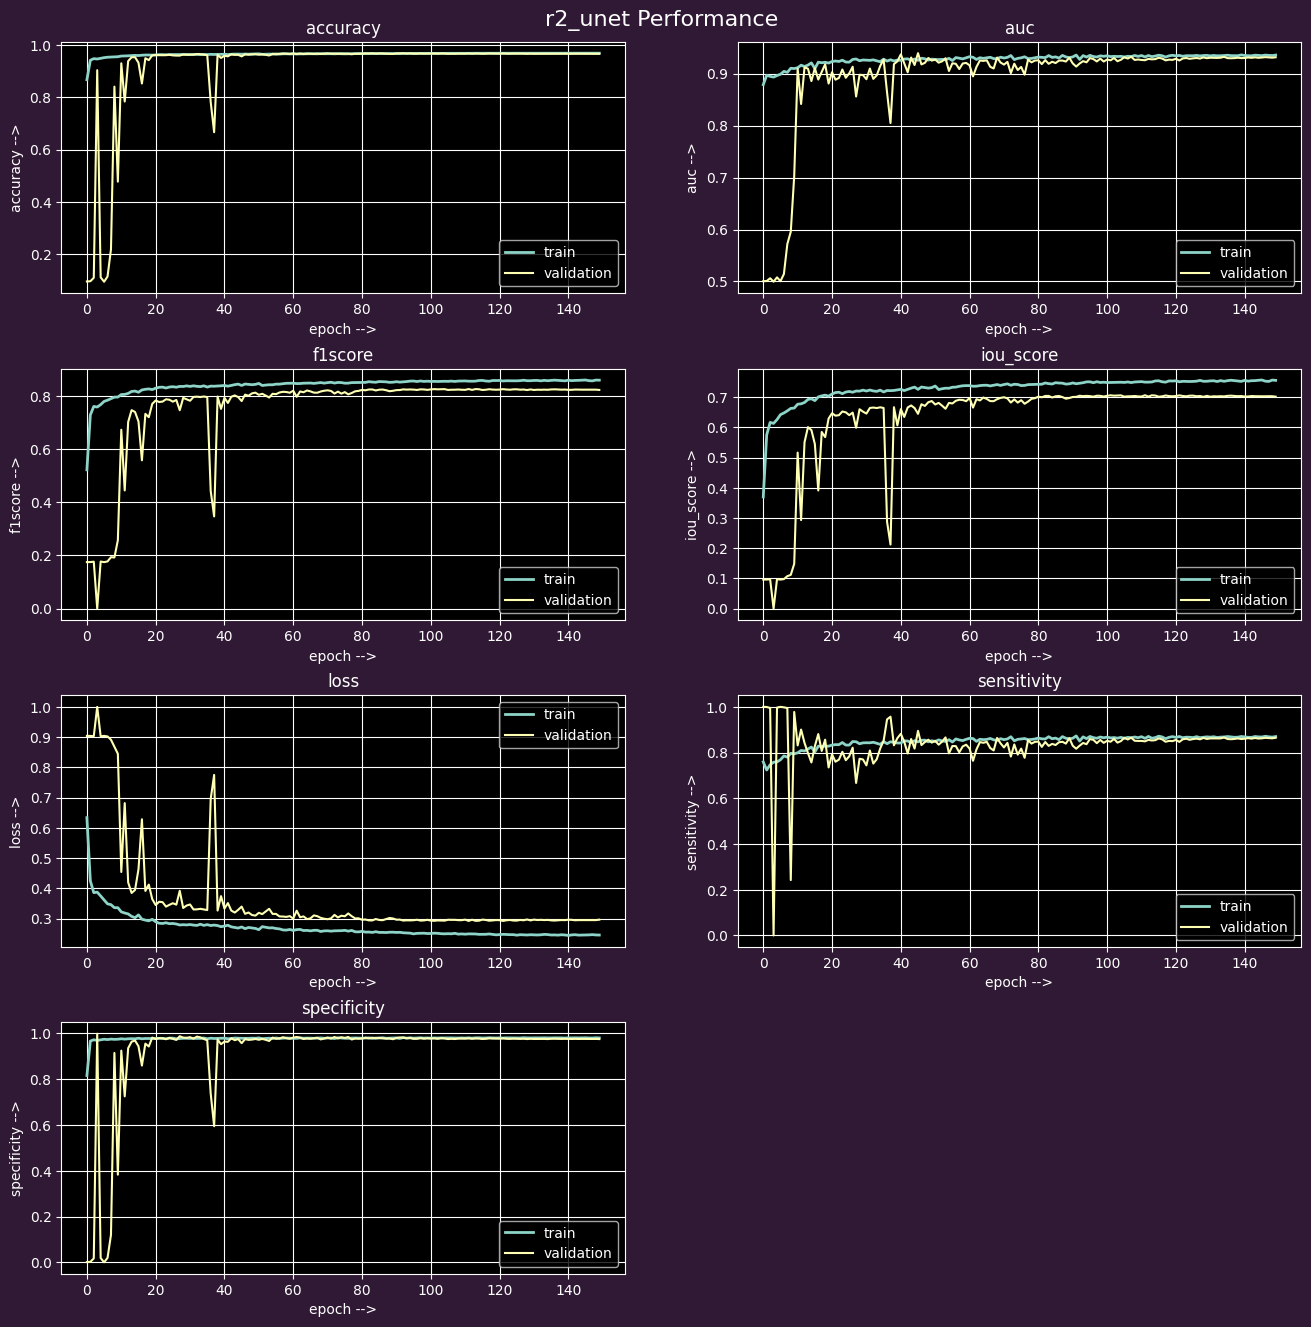

In [51]:
# model_name = "unet"
# History = History_dict[ model_name]

metric_List = list(History.keys())


plt.figure(figsize = (16,16),facecolor='#301934').suptitle(model_name+" Performance",fontsize=16, y=0.90)
for i,metric in enumerate(metric_List[:7],1):
    plt.subplot(4,2,i)
    plt.plot(History[metric],label='train',linewidth=2)
    plt.plot(History['val_'+ metric],label='validation',linewidth=1.5)
    plt.title(metric)
    plt.legend()
    plt.ylabel(metric + ' -->')
    plt.xlabel('epoch -->')
    plt.subplots_adjust(wspace=0.2, hspace=0.3) 
    plt.grid()
plt.show()

### > comparision plot

### > Sample Predictions

In [52]:
def get_pred_mask(image):
    return Model.predict(tf.expand_dims(image,axis=0),verbose=0)[0]

In [53]:
# def get_aug_image(image):
#     mask_pred_1 = get_pred_mask(image)
    
#     mask_pred_2 = get_pred_mask(np.fliplr(image))
#     mask_pred_2 = np.fliplr(mask_pred_2)
    
#     mask_pred_3 = get_pred_mask(np.flipud(image))
#     mask_pred_3 = np.flipud(mask_pred_3)
    
#     # mask_pred_4 = get_pred_mask(np.flipud(np.fliplr(image)))
#     # mask_pred_4 = np.flipud(np.fliplr(mask_pred_4))
    
#     mask_pred_aug = (mask_pred_1 + mask_pred_2 + mask_pred_3 )/3
#     return mask_pred_1 ,mask_pred_aug

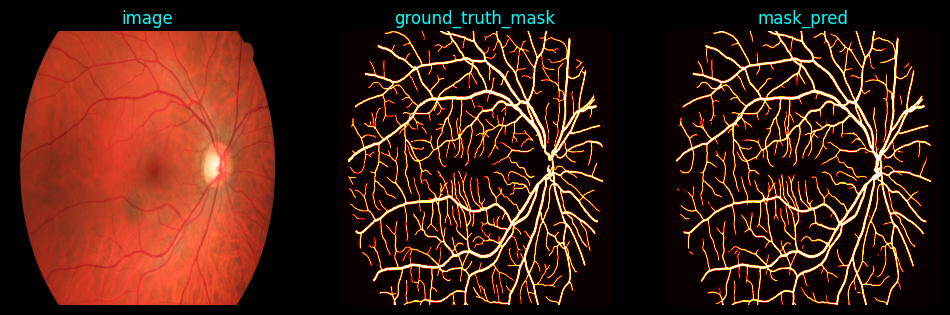

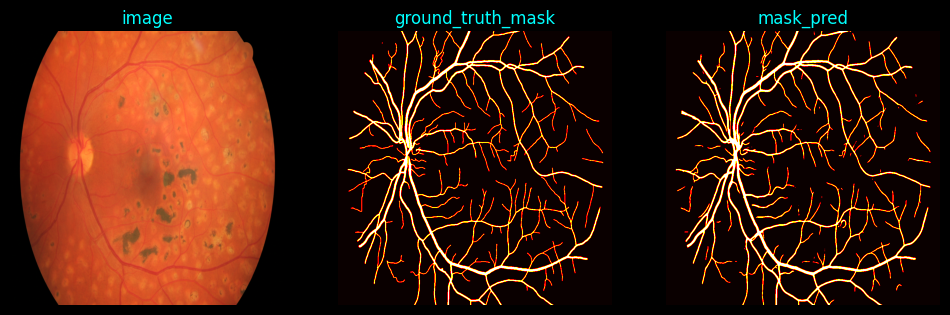

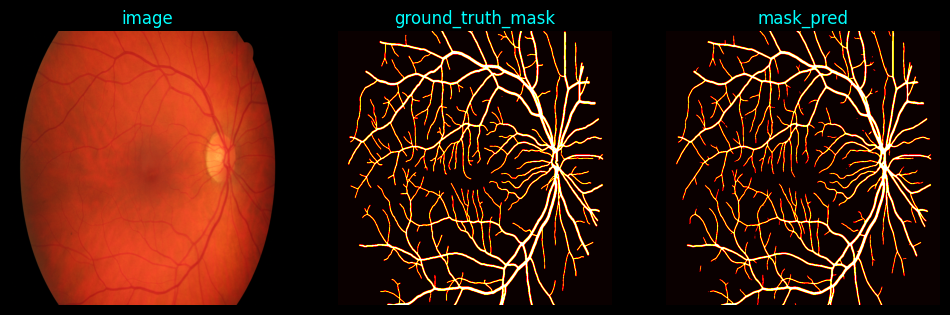

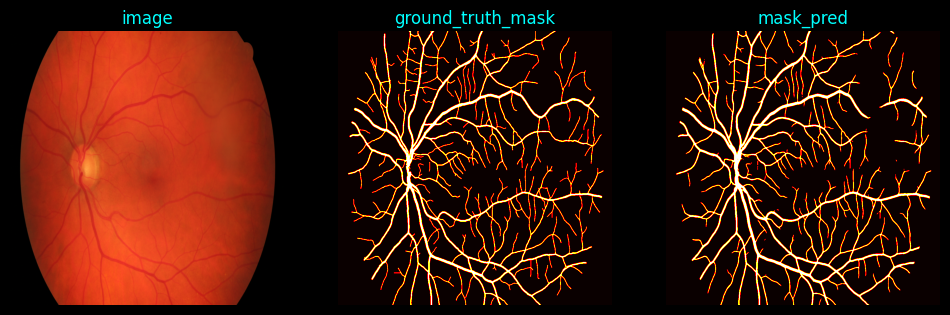

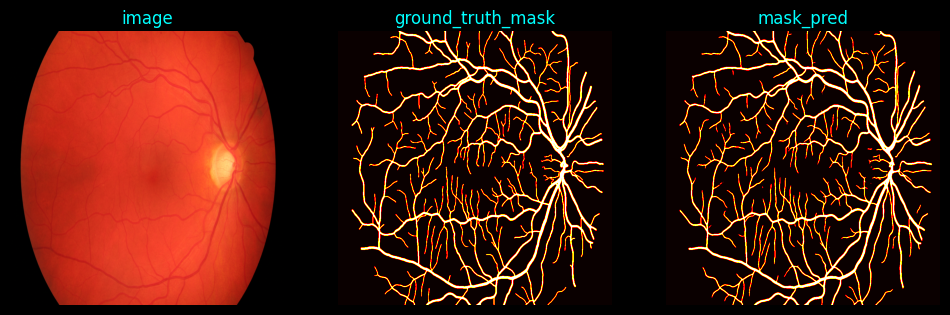

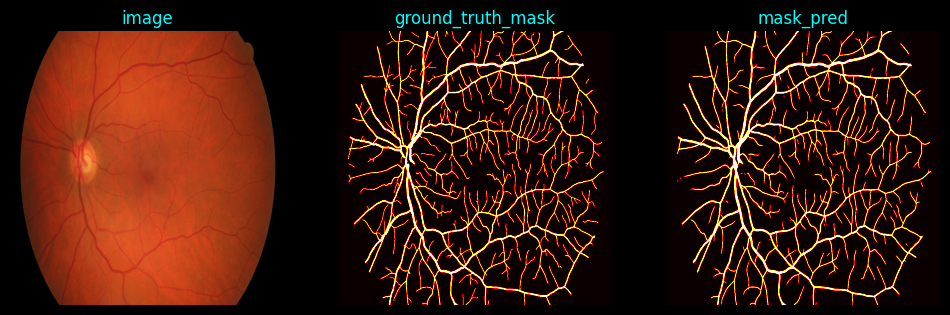

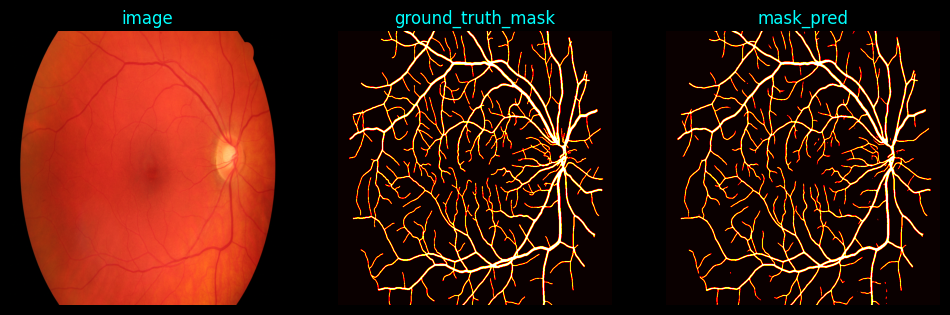

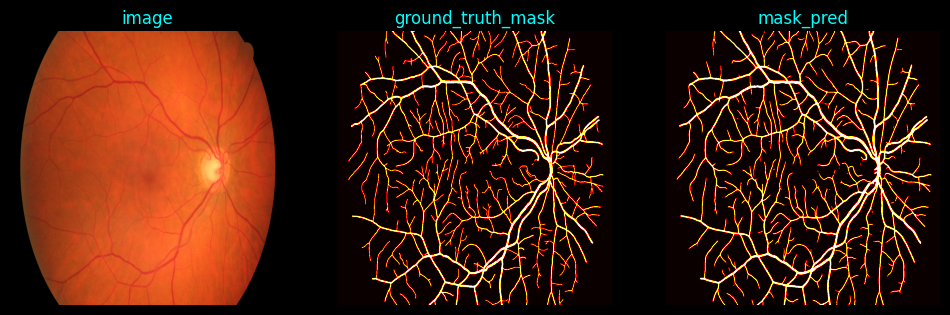

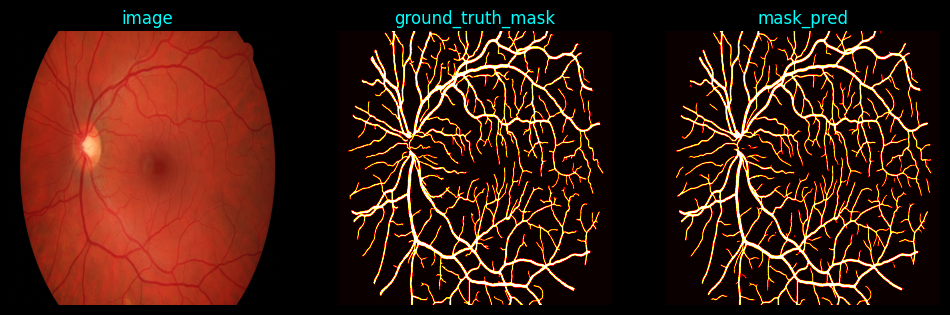

In [54]:
threshold = 0.5
for image , mask in zip(test_images , test_masks):
# for image , mask in zip(test_images , test_masks):
    
#     print(image.min() ,image.max() , mask.min() ,mask.max())
#     mask_pred , mask_pred_aug = get_aug_image(image)
    mask_pred = get_pred_mask(image)
    
    mask_pred = (mask_pred>threshold)
#     mask_pred_aug = (mask_pred_aug > threshold)
        
    image = (image-image.min()) / (image.max()-image.min()) 
    
    display_images([image[...,:3] ,mask,mask_pred],['image','ground_truth_mask','mask_pred','mask_pred_aug'],size = 4,cmap='hot')

In [ ]:
# np.max(new_image)

In [ ]:
new_image = prev_Model(train_images[index:index+1])[0]
display_images([train_images[index][...,:3],new_image ,train_masks[index],],cmap = 'gray',size = 6,scaling='minmax',grid=(1,3))

In [ ]:
def image_gaus_edge(image,thresh1= 50 , kernel_size = 5,channel = None):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if(np.ndim(image)==3):
        if(channel):
            gray =  image[...,channel]
        else :
            gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    # print(np.shape(image))
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    # Apply edge detection using Canny
    edge = cv2.Canny(blurred, threshold1=thresh1, threshold2=100)  # Adjust thresholds as needed

    return edge

In [ ]:
min_ = np.min(new_image ,axis = (0,1))
max_ = np.max(new_image ,axis = (0,1)) 

new_image = 255*(new_image - min_) /( max_ - min_)
new_image = np.array( new_image , dtype ='uint8')

In [ ]:
img_edge_1= image_gaus_edge(new_image, 300,3,channel=1)
img_edge_2= image_gaus_edge(new_image, 100,5,channel=0)
display_images([img_edge_1,img_edge_2,new_image,train_masks[index]] ,size=5,cmap = 'gray' , grid=(3,2))

## > Saving Results

In [ ]:
# [ 'pretrained_unet' ,'residual_unet' ,'r2_unet' , 'residual_attention_aunet']

In [56]:
import json

In [ ]:
with open(base_path+'dataset/account_content','r') as file:
    content = file.read()
Folder_key_dict  = json.loads(content)
# Address_dict

In [ ]:
# pip install mediafire

In [ ]:
from mediafire import MediaFireApi
from mediafire import MediaFireUploader
api = MediaFireApi()
uploader = MediaFireUploader(api)

In [57]:
def upload_models():
    base_path = 'Models' 
    try:
        os.mkdir(base_path)
    except:
        pass
        
#     folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
#     print(folder_key)
    
    for model_name , model in Model_dict.items():
        model_save_path = base_path + '/' + model_name + '.keras'
        model.save(model_save_path)

#         session = api.user_get_session_token(
#                         email='prajwalsharma.bt21cse@pec.edu.in',
#                         password='Praju@321',
#                         app_id='42511',
#         )
        
#         api.session = session
    
#         try:
#             print(model_name ,'upload started >>>')
#             with open(model_save_path ,'rb') as model_file:
#                 uploader = MediaFireUploader(api)
#                 %time result = uploader.upload(model_file , model_name , folder_key=folder_key)
#             print(model_name ,'uploaded successfully')
#             print('------------------------------------------------------------------------------------')
#         except Exception as e:
#             print("Error :",e)

In [58]:
def upload_Dict(Dict , dict_name = 'history_dict3'):
    base_path = 'Meta' 
    try:
        os.mkdir(base_path)
    except:
        pass
    
#     folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
#     print(folder_key)
    
    dict_file_name = base_path + '/' + dict_name+'.txt'
    
    dict_str = dict_str = json.dumps(Dict)
    dict_str = dict_str.encode()
    with open(dict_file_name,'wb') as dict_file :
        dict_file.write(dict_str)

#     session = api.user_get_session_token(
#                     email='prajwalsharma.bt21cse@pec.edu.in',
#                     password='Praju@321',
#                     app_id='42511',
#     )
#     api.session = session

#     try:
#         with open(dict_file_name ,'rb') as dict_file:
#             dict_str2 = dict_file.read()
#             Dict2 = json.loads(dict_str2)
            
#             uploader = MediaFireUploader(api)
#             %time result = uploader.upload(dict_file , dict_name , folder_key=folder_key) 
    
#     except Exception as e:
#         print("Error :",e)

In [59]:
upload_models()

In [60]:
upload_Dict(History_dict)

In [ ]:
# Model = models.load_model('Models/pretrained_unet_keras',compile=False)
# Model.evaluate(test_images,test_masks)

In [ ]:
# with open('Meta/history_dict_.txt' ,'rb') as dict_file:
#     dict_str2 = dict_file.read()
# Dict2 = json.loads(dict_str2)
# Dict2

In [ ]:
api = MediaFireApi()
# uploader = MediaFireUploader(api)

session = api.user_get_session_token(
                email='prajwalsharma.bt21cse@pec.edu.in',
                password='Praju@321',
                app_id='42511',
)